# In this file we calibrate the Heston model through the pointwise approach
In the forward pass we learn the **mapping** between **Heston parameters** and the option **implied volatility**, In this case the implied volatility surface is on a fixed grid 11(strikes)x8(maturities), the same used for the image based approach, here we will unroll it in order to handle the single option.
Below we upload the dataset .

In [1]:
#Set the directory of stored dataset
import os
os.chdir("C:/Users/pc/Desktop/politecnico/TESI/mio codice/Heston/grid based")

In [2]:
#import libraries
import gzip
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
#Open compressed dataset

f = gzip.GzipFile('HestonTrainSet.txt.gz', "r")
dat=np.load(f) #load data in a numpy array
xx=dat[:,:5]   #extract first 5 columns (Heston parameters)
yy=dat[:,5:]   #extract last  columns ()

#define strikes and maturities
strikes=np.array([0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5 ])
maturities=np.array([0.1,0.3,0.6,0.9,1.2,1.5,1.8,2.0 ])

# Print shapes with descriptive messages
print("Shape of the full dataset (samples × (parameters + implied_vols)):", dat.shape)
print("\nInput (Heston parameter sets) shape (samples × 5 parameters):", xx.shape)
print("  - Each row contains: [ν₀, ρ, γ, θ, κ]")
print("\nTarget (Implied Volatility Surfaces) shape (samples × (maturities × strikes)):", yy.shape)
print(f"  - Each row represents a {len(maturities)}×{len(strikes)} grid (maturities × strikes)")

Shape of the full dataset (samples × (parameters + implied_vols)): (12000, 93)

Input (Heston parameter sets) shape (samples × 5 parameters): (12000, 5)
  - Each row contains: [ν₀, ρ, γ, θ, κ]

Target (Implied Volatility Surfaces) shape (samples × (maturities × strikes)): (12000, 88)
  - Each row represents a 8×11 grid (maturities × strikes)


# Let's have a look at the dataset and gain some more informations


=== HESTON PARAMETERS ANALYSIS (xx) ===
       ν₀ (initial variance)  ρ (spot-vol correlation)  γ (vol of variance)  \
count             12000.0000                12000.0000           12000.0000   
mean                  0.0174                   -0.3479               0.6606   
std                   0.0121                    0.2078               0.3311   
min                   0.0001                   -0.9498               0.0100   
1%                    0.0002                   -0.9146               0.0170   
5%                    0.0006                   -0.7903               0.0438   
50%                   0.0163                   -0.2810               0.8011   
95%                   0.0375                   -0.1169               0.9846   
99%                   0.0395                   -0.1036               0.9972   
max                   0.0400                   -0.1000               1.0000   

       θ (mean reverting level of variance)  κ (speed of mean reversion)  
count         

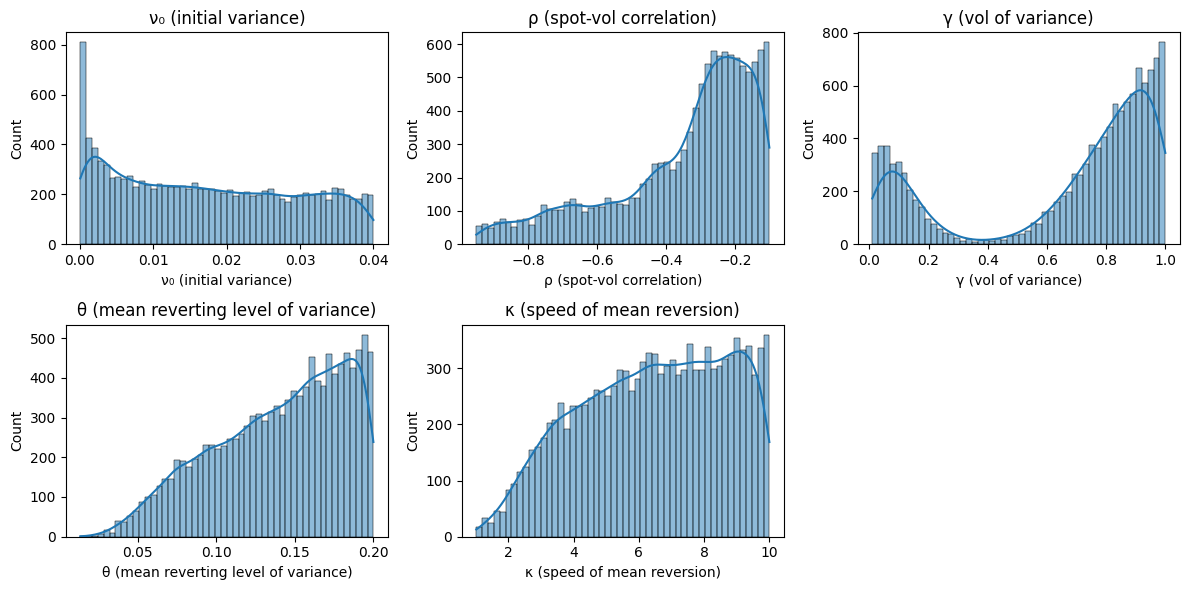


=== IMPLIED VOLATILITY SURFACE ANALYSIS (yy) ===
Global mean: 0.3220
Global min: 0.0845
Global max: 0.5618

Volatility matrix for strikes/maturities (first sample):
        0.5     0.6     0.7     0.8     0.9     1.0     1.1     1.2     1.3  \
0.1  0.3513  0.3213  0.2948  0.2729  0.2590  0.2582  0.2694  0.2852  0.3014   
0.3  0.3629  0.3489  0.3395  0.3346  0.3336  0.3357  0.3399  0.3455  0.3517   
0.6  0.3730  0.3687  0.3667  0.3664  0.3672  0.3689  0.3711  0.3737  0.3765   
0.9  0.3796  0.3783  0.3780  0.3785  0.3794  0.3807  0.3822  0.3838  0.3856   
1.2  0.3842  0.3839  0.3842  0.3848  0.3857  0.3867  0.3878  0.3890  0.3902   
1.5  0.3874  0.3875  0.3880  0.3887  0.3894  0.3903  0.3912  0.3921  0.3930   
1.8  0.3898  0.3901  0.3906  0.3913  0.3920  0.3927  0.3934  0.3942  0.3949   
2.0  0.3911  0.3915  0.3920  0.3926  0.3932  0.3939  0.3946  0.3952  0.3959   

        1.4     1.5  
0.1  0.3167  0.3307  
0.3  0.3583  0.3648  
0.6  0.3794  0.3824  
0.9  0.3873  0.3891  
1.2  0.3915 

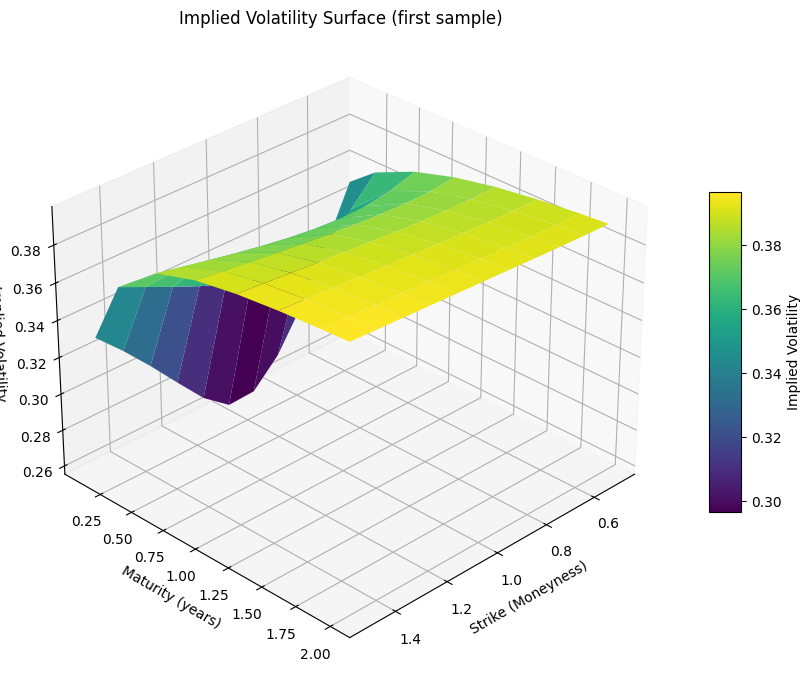

In [3]:
import seaborn as sns

#INPUT (HESTON PARAMETERS) ANALYSIS 

# Heston parameter names (for clarity)
#v0    ∈ [0.0001, 0.04]        (initial variance)
#rho   ∈ [-0.95, -0.1]         (spot-vol correlation)
#gamma ∈ [0.01, 1.0]           (vol of variance)
#theta ∈ [0.01, 0.2]           (mean reverting level of variance)
#kappa ∈ [1, 10.0]             (speed of mean reversion)
param_names = [
    'ν₀ (initial variance)',
    'ρ (spot-vol correlation)',
    'γ (vol of variance)',
    'θ (mean reverting level of variance)',
    'κ (speed of mean reversion)',
]


# Create DataFrame for statistical analysis
df_xx = pd.DataFrame(xx, columns=param_names)

# Descriptive statistics
print("\n=== HESTON PARAMETERS ANALYSIS (xx) ===")
print(df_xx.describe(percentiles=[0.01, 0.05, 0.95, 0.99]).round(4))

# Validate physical bounds
print("\n=== PHYSICAL BOUNDS ===")
print(f"ν₀:    Min={df_xx.iloc[:,0].min():.4f}, Max={df_xx.iloc[:,0].max():.4f} (Expected: ~[0.0001, 0.04])")
print(f"ρ:   Min={df_xx.iloc[:,1].min():.4f}, Max={df_xx.iloc[:,1].max():.4f} (Expected: ~[-0.95, -0.1])")
print(f"κ: Min={df_xx.iloc[:,4].min():.4f}, Max={df_xx.iloc[:,4].max():.4f} (Expected: ~[1, 10])")

# Plot distributions
plt.figure(figsize=(12, 6))
for i, col in enumerate(df_xx.columns):
    plt.subplot(2, 3, i+1)
    sns.histplot(df_xx[col], bins=50, kde=True)
    plt.title(col)
plt.tight_layout()
plt.show()

#OUTPUT (IMPLIED VOLATILTY SURFACE) ANALYSIS 
print("\n=== IMPLIED VOLATILITY SURFACE ANALYSIS (yy) ===")

# Global statistics
print(f"Global mean: {yy.mean():.4f}")
print(f"Global min: {yy.min():.4f}")
print(f"Global max: {yy.max():.4f}")

# Reshape first sample into strike/maturity matrix
vol_matrix = yy[0].reshape(len(maturities), len(strikes))
df_vol = pd.DataFrame(vol_matrix, index=maturities, columns=strikes)

print("\nVolatility matrix for strikes/maturities (first sample):")
print(df_vol.round(4))

# Create 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Create grid for surface plot
X, Y = np.meshgrid(strikes, maturities)

# Plot surface
surf = ax.plot_surface(X, Y, vol_matrix, cmap='viridis', edgecolor='none')

# Add color bar
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, label='Implied Volatility')

# Set labels and title
ax.set_xlabel('Strike (Moneyness)')
ax.set_ylabel('Maturity (years)')
ax.set_zlabel('Implied Volatility')
ax.set_title('Implied Volatility Surface (first sample)')

# Adjust view angle for better visualization
ax.view_init(30, 45)

# Adjust layout to prevent clipping
plt.tight_layout(pad=4.0)
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9)

plt.show()

# Step 1: Data Generation


## **Inputs:** 
###  1. $\nu_{0}$ inital variance
###  2. $\rho$ spot-vol correlation
###  3. $\gamma$ vol of variance
###  4. $\theta$ mean reverting level of variance
###  5. $\kappa$ speed of mean reversion 
###  6. $K$ option strike price
###  7. $T$ option maturity
    
## **Output:**
### Option Implied volatility 

# Prepare dataset to handle pointwise
Now we need to unroll the implied volatility surfaces, decoupling them into single options, in order to create the dataset properly. 
This will result in the input dataset having dimension: (n_samples, 7), 7 since we incorporate strike and maturity to the parameter set, the output consists only of the implied volatility of that option.


=== Dimension Verification ===
Original Heston params shape: (12000, 5)
Original IV surfaces shape: (12000, 88)
Pointwise X shape: (1056000, 7) (should be (1056000 , 7))
Pointwise y shape: (1056000,) (should be 1056000,)

First sample verification (sample_idx=0):
First 5 Heston params: [ 0.01683994 -0.12410636  0.87622854  0.16472127  9.58028822]
First strike/maturity: [0.5 0.1]
Corresponding IV: 0.3512746423367083


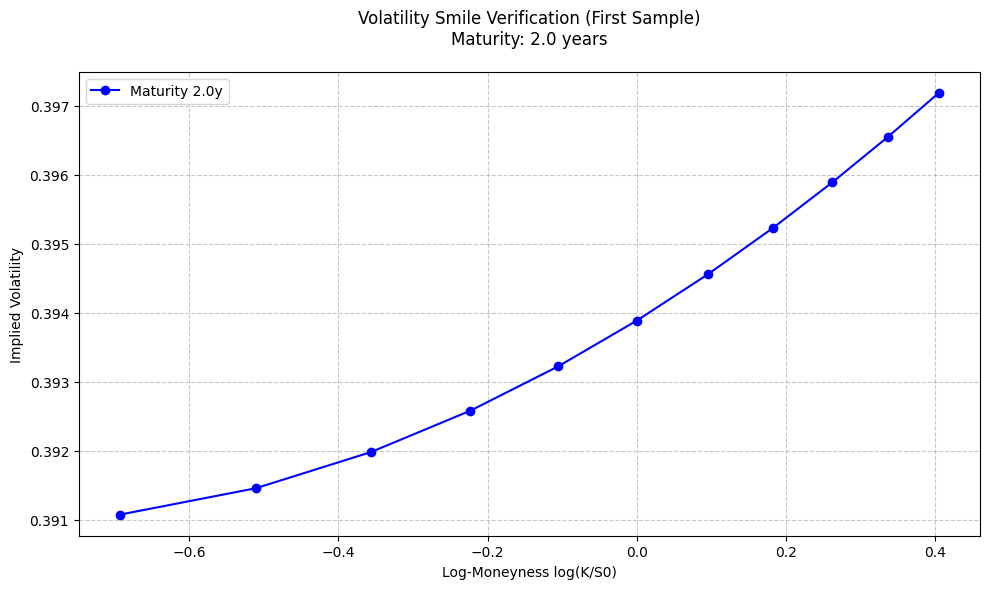


=== Pointwise Dataset Sample ===
   sample_idx  strike  maturity  log_moneyness  implied_vol
0           0     0.5       0.1      -0.693147     0.351275
1           0     0.6       0.1      -0.510826     0.321272
2           0     0.7       0.1      -0.356675     0.294827
3           0     0.8       0.1      -0.223144     0.272889
4           0     0.9       0.1      -0.105361     0.258973


In [4]:
# WE NEED TO UNROLL THE IV SURFACES INTO SINGLE IV
# =====================================================================================
# POINTWISE DATASET PREPARATION
# =====================================================================================

def create_pointwise_dataset(x_params, y_vols, strikes, maturities,S0=1.0):
    """
    Unrolls IV surfaces into pointwise dataset where each row contains:
    [Heston_params (5), strike, maturity] → implied_volatility
    
    Args:
        x_params: Array of Heston parameters (n_samples, 5)
        y_vols: Array of implied volatility surfaces (n_samples, n_maturities*n_strikes)
        strikes: Array of strike values
        maturities: Array of maturity values
        
    Returns:
        X_pw: Combined input features (n_samples*n_points, 7)
        y_pw: Output volatilities (n_samples*n_points,)
        df_info: DataFrame with metadata for each point
    """
    # Verify input shapes
    n_samples = x_params.shape[0]
    n_strikes = len(strikes)
    n_maturities = len(maturities)
    
    assert y_vols.shape == (n_samples, n_strikes * n_maturities), \
           f"y_vols shape {y_vols.shape} doesn't match {n_strikes}*{n_maturities}={n_strikes*n_maturities}"
    
    # Create strike/maturity grid (row-major order: all strikes for each maturity)
    strike_grid, maturity_grid = np.meshgrid(strikes, maturities)
    strikes_flat = strike_grid.ravel()  # Flatten to 1D (order: all strikes for maturity 1, then maturity 2...)
    maturities_flat = maturity_grid.ravel()
    
    # Repeat Heston params for each strike/maturity combination
    X_repeated = np.repeat(x_params, n_strikes*n_maturities, axis=0)
    
    # Tile strikes and maturities for each sample
    strikes_tiled = np.tile(strikes_flat, n_samples)
    maturities_tiled = np.tile(maturities_flat, n_samples)
    
    # Combine into final datasets
    X_pw = np.column_stack([X_repeated, strikes_tiled, maturities_tiled])
    y_pw = y_vols.ravel()  # Flatten all IV surfaces
    
    # Create metadata DataFrame
    df_info = pd.DataFrame({
        'sample_idx': np.repeat(np.arange(n_samples), n_strikes*n_maturities),
        'strike': strikes_tiled,
        'maturity': maturities_tiled,
        'log_moneyness': np.log(strikes_tiled/S0),
        'implied_vol': y_pw
    })
    
    return X_pw, y_pw, df_info

# Create pointwise dataset
X_pw, y_pw, df_pw = create_pointwise_dataset(xx, yy, strikes, maturities)

# =================================================================
# DIMENSION VERIFICATION
# =================================================================
print("\n=== Dimension Verification ===")
print(f"Original Heston params shape: {xx.shape}")
print(f"Original IV surfaces shape: {yy.shape}")
print(f"Pointwise X shape: {X_pw.shape} (should be ({xx.shape[0]*len(strikes)*len(maturities)} , {xx.shape[1]+2}))")
print(f"Pointwise y shape: {y_pw.shape} (should be {xx.shape[0]*len(strikes)*len(maturities)},)")

# Verify first sample
sample_idx = 0  # First sample
n_points_per_surface = len(strikes) * len(maturities)
print(f"\nFirst sample verification (sample_idx={sample_idx}):")
print(f"First 5 Heston params: {X_pw[sample_idx*n_points_per_surface, :5]}")
print(f"First strike/maturity: {X_pw[sample_idx*n_points_per_surface, 5:]}")
print(f"Corresponding IV: {y_pw[sample_idx*n_points_per_surface]}")

# =================================================================
# SMILE PLOT VERIFICATION (Last maturity of first sample)
# =================================================================
last_maturity_idx = 7
first_sample_start = sample_idx * n_points_per_surface
first_sample_end = (sample_idx + 1) * n_points_per_surface

# Extract all points for first sample
sample_strikes = X_pw[first_sample_start:first_sample_end, 5]
sample_maturities = X_pw[first_sample_start:first_sample_end, 6]
sample_vols = y_pw[first_sample_start:first_sample_end]

# Filter for first maturity only
first_maturity_mask = sample_maturities == maturities[last_maturity_idx]
maturity_vols = sample_vols[first_maturity_mask]
maturity_strikes = sample_strikes[first_maturity_mask]
log_moneyness = np.log(maturity_strikes / 1.0)  # S0 = 1.0

plt.figure(figsize=(10, 6))
plt.plot(log_moneyness, maturity_vols, 'bo-', label=f"Maturity {maturities[last_maturity_idx]}y")
plt.title(f"Volatility Smile Verification (First Sample)\nMaturity: {maturities[last_maturity_idx]} years", pad=20)
plt.xlabel("Log-Moneyness log(K/S0)")
plt.ylabel("Implied Volatility")
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

# =================================================================
# DATAFRAME SAMPLE OUTPUT
# =================================================================
print("\n=== Pointwise Dataset Sample ===")
print(df_pw.iloc[:5])  # Show first 5 rows

# Train-val-test split
In the following snippet we perform the usual trainining-validation-test split, but we need to be careful, this split is not completely random. In fact we need to handle the dataset not at a single-option level, but to parameter set level, meaning that we need to **preserve the integrity** of each surface referring to a parameter set, ESPECIALLY on the test set, where we will calibrate each IV surface.

In [5]:
def split_parameter_blocks(X_pw, y_pw, df_info, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, random_seed=None):
    """
    Splits the dataset into train/val/test sets while keeping all strike-maturity combinations
    for each Heston parameter set together (no mixing of parameter sets across splits).
    
    Args:
        X_pw: Pointwise features array (n_samples*n_points, 7)
        y_pw: Pointwise target array (n_samples*n_points,)
        df_info: Metadata DataFrame with sample_idx, strike, maturity, etc.
        train_ratio: Fraction of parameter sets for training
        val_ratio: Fraction of parameter sets for validation
        test_ratio: Fraction of parameter sets for testing
        random_seed: Optional random seed for reproducibility
        
    Returns:
        Split datasets (X_train, y_train, df_train), (X_val, y_val, df_val), (X_test, y_test, df_test)
    """
    # Verify ratios sum to 1
    assert np.isclose(train_ratio + val_ratio + test_ratio, 1.0), "Ratios must sum to 1"
    
    # Get unique parameter set indices and counts
    unique_samples = df_info['sample_idx'].unique()
    n_samples = len(unique_samples)
    points_per_sample = len(df_info[df_info['sample_idx'] == 0])  # Should be 88
    
    print(f"Total parameter sets: {n_samples}")
    print(f"Points per parameter set: {points_per_sample}")
    print(f"Total points: {len(X_pw)} (should be {n_samples * points_per_sample})")
    
    # Split parameter set indices (not the points themselves)
    if random_seed is not None:
        np.random.seed(random_seed)
    shuffled_indices = np.random.permutation(unique_samples)
    
    train_end = int(n_samples * train_ratio)
    val_end = train_end + int(n_samples * val_ratio)
    
    train_samples = shuffled_indices[:train_end]
    val_samples = shuffled_indices[train_end:val_end]
    test_samples = shuffled_indices[val_end:]
    
    print(f"\nSplit counts:")
    print(f"Training parameter sets: {len(train_samples)} ({len(train_samples)/n_samples:.1%})")
    print(f"Validation parameter sets: {len(val_samples)} ({len(val_samples)/n_samples:.1%})")
    print(f"Test parameter sets: {len(test_samples)} ({len(test_samples)/n_samples:.1%})")
    
    # Create masks for each split
    train_mask = df_info['sample_idx'].isin(train_samples)
    val_mask = df_info['sample_idx'].isin(val_samples)
    test_mask = df_info['sample_idx'].isin(test_samples)
    
    # Apply masks to get splits
    X_train, y_train = X_pw[train_mask], y_pw[train_mask]
    X_val, y_val = X_pw[val_mask], y_pw[val_mask]
    X_test, y_test = X_pw[test_mask], y_pw[test_mask]
    
    df_train = df_info[train_mask].copy()
    df_val = df_info[val_mask].copy()
    df_test = df_info[test_mask].copy()
    
    # Verify no leakage between splits
    assert len(set(df_train['sample_idx']).intersection(set(df_val['sample_idx']))) == 0
    assert len(set(df_train['sample_idx']).intersection(set(df_test['sample_idx']))) == 0
    assert len(set(df_val['sample_idx']).intersection(set(df_test['sample_idx']))) == 0
    
    # Verify all points from each parameter set stay together
    for df in [df_train, df_val, df_test]:
        sample_counts = df['sample_idx'].value_counts()
        assert all(sample_counts == points_per_sample), "Parameter sets were split incorrectly!"
    
    print("\nVerification passed - all parameter sets remain intact in their respective splits")
    
    return (X_train, y_train, df_train), (X_val, y_val, df_val), (X_test, y_test, df_test)

(X_train, y_train, df_train), (X_val, y_val, df_val), (X_test, y_test, df_test) = \
    split_parameter_blocks(X_pw, y_pw, df_pw, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, random_seed=42)

# =================================================================
# SPLIT VERIFICATION
# =================================================================
print("\n=== Split Shapes ===")
print(f"Training set: {X_train.shape} (should be ~{len(X_pw)*0.7:.0f} points)")
print(f"Validation set: {X_val.shape} (should be ~{len(X_pw)*0.15:.0f} points)")
print(f"Test set: {X_test.shape} (should be ~{len(X_pw)*0.15:.0f} points)")

print("\n=== Sample Distribution ===")
print("Training parameter sets:", df_train['sample_idx'].unique()[:5], "...")
print("Validation parameter sets:", df_val['sample_idx'].unique()[:5], "...")
print("Test parameter sets:", df_test['sample_idx'].unique()[:5], "...")

Total parameter sets: 12000
Points per parameter set: 88
Total points: 1056000 (should be 1056000)

Split counts:
Training parameter sets: 8400 (70.0%)
Validation parameter sets: 1800 (15.0%)
Test parameter sets: 1800 (15.0%)

Verification passed - all parameter sets remain intact in their respective splits

=== Split Shapes ===
Training set: (739200, 7) (should be ~739200 points)
Validation set: (158400, 7) (should be ~158400 points)
Test set: (158400, 7) (should be ~158400 points)

=== Sample Distribution ===
Training parameter sets: [ 0  2  3  8 10] ...
Validation parameter sets: [ 6  7 11 13 16] ...
Test parameter sets: [ 1  4  5  9 38] ...


In [6]:
# NOW WE CAN SHUFFLE RANDOMLY THE TRAINING AND THE VALIDATION SET AS WE NEED TO APPROXIMATE THE OPTION PRICING FUNCTION
# ======================================================================================
def shuffle_within_splits(X_train, y_train, df_train, X_val, y_val, df_val, random_seed=None):
    """
    Shuffles data points within training and validation sets while preserving:
    - The test set remains unchanged (critical for calibration)
    - All columns stay aligned during shuffling
    - DataFrame indices are reset for clean tracking
    
    Args:
        X_train: Training features (n_points, 7)
        y_train: Training targets (n_points,)
        df_train: Training metadata DataFrame
        X_val: Validation features (n_points, 7)
        y_val: Validation targets (n_points,)
        df_val: Validation metadata DataFrame
        random_seed: Optional seed for reproducibility
        
    Returns:
        Shuffled versions of all training/validation inputs
    """
    if random_seed is not None:
        np.random.seed(random_seed)
    
    # Create shuffling indices
    train_shuffle_idx = np.random.permutation(len(X_train))
    val_shuffle_idx = np.random.permutation(len(X_val))
    
    # Apply shuffling to arrays
    X_train_shuffled = X_train[train_shuffle_idx]
    y_train_shuffled = y_train[train_shuffle_idx]
    
    X_val_shuffled = X_val[val_shuffle_idx]
    y_val_shuffled = y_val[val_shuffle_idx]
    
    # Apply shuffling to DataFrames (must reset index)
    df_train_shuffled = df_train.iloc[train_shuffle_idx].reset_index(drop=True)
    df_val_shuffled = df_val.iloc[val_shuffle_idx].reset_index(drop=True)
    
    # Verify shuffling
    print("\n=== Shuffling Verification ===")
    print("Training set order changed:", not np.array_equal(X_train_shuffled[:5], X_train[:5]))
    print("Validation set order changed:", not np.array_equal(X_val_shuffled[:5], X_val[:5]))
    print("DataFrame-array alignment check:")
    print("- Training:", np.allclose(X_train_shuffled[:,5], df_train_shuffled['strike'].values))
    print("- Validation:", np.allclose(X_val_shuffled[:,5], df_val_shuffled['strike'].values))
    
    return X_train_shuffled, y_train_shuffled, df_train_shuffled, X_val_shuffled, y_val_shuffled, df_val_shuffled

# Apply shuffling (keeping test set intact)
(X_train, y_train, df_train_shuffled, 
 X_val, y_val, df_val_shuffled) = shuffle_within_splits(
    X_train, y_train, df_train, 
    X_val, y_val, df_val,
    random_seed=42
)

# =================================================================
# POST-SHUFFLING VERIFICATION
# =================================================================
def verify_shuffling(original_df, shuffled_df, set_name):
    """Verifies shuffling preserved parameter set integrity"""
    # Check all original samples are present
    original_samples = set(original_df['sample_idx'].unique())
    shuffled_samples = set(shuffled_df['sample_idx'].unique())
    assert original_samples == shuffled_samples, f"{set_name} lost parameter sets!"
    
    # Check all points for each sample are present
    sample_counts = original_df['sample_idx'].value_counts().sort_index()
    shuffled_counts = shuffled_df['sample_idx'].value_counts().sort_index()
    assert sample_counts.equals(shuffled_counts), f"{set_name} point counts changed!"
    
    print(f"{set_name} verification passed - all parameter sets preserved")

print("\n=== Post-Shuffling Integrity Check ===")
verify_shuffling(df_train, df_train_shuffled, "Training set")
verify_shuffling(df_val, df_val_shuffled, "Validation set")

# Show before/after sample
print("\n=== Training Set Order (Before vs After) ===")
print("Original first 5 samples:")
print(df_train[['sample_idx', 'strike', 'maturity']].head())
print("\nShuffled first 5 samples:")
print(df_train_shuffled[['sample_idx', 'strike', 'maturity']].head())



=== Shuffling Verification ===
Training set order changed: True
Validation set order changed: True
DataFrame-array alignment check:
- Training: True
- Validation: True

=== Post-Shuffling Integrity Check ===
Training set verification passed - all parameter sets preserved
Validation set verification passed - all parameter sets preserved

=== Training Set Order (Before vs After) ===
Original first 5 samples:
   sample_idx  strike  maturity
0           0     0.5       0.1
1           0     0.6       0.1
2           0     0.7       0.1
3           0     0.8       0.1
4           0     0.9       0.1

Shuffled first 5 samples:
   sample_idx  strike  maturity
0        7885     1.0       0.6
1        6611     1.1       1.2
2        8698     0.5       0.9
3        8246     1.3       0.3
4        4386     1.1       2.0


# Scaling:
Now we can finally scale both the parameters as shown below and the implied volatilities, this will improve the numerical stability of the training and calibration procedure.

# Model Parameters ${\theta}_{i=1,..,5}\to scale(\theta_i)\in[-1,1]$
## $scale(\theta_i)=\frac{2\theta_i-(\theta_i^{max}+\theta_i^{min})}{\theta_i^{max}-\theta_i^{min}},\quad i \in |\Theta|$

# Implied volatilities
## $$scale(\sigma^{BS}_{i,j})=\frac{\sigma^{BS}_{i,j}-\mathbb{E}[\sigma^{BS}_{i,j}]}{std(\sigma^{BS}_{i,j})},\quad i\in\text{Maturities},\; j\in \text{Strikes}$$

In [7]:
from sklearn.preprocessing import StandardScaler
from tabulate import tabulate

# =================================================================
# 1. IMPLIED VOLATILITY SCALING (StandardScaler)
# =================================================================
scaler_yy = StandardScaler()

# Reshape y arrays to 2D if needed (StandardScaler expects 2D input)
y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# Apply scaling
y_train_transform = scaler_yy.fit_transform(y_train)  # Compute μ and σ on training set
y_val_transform = scaler_yy.transform(y_val)          # Use same μ and σ
y_test_transform = scaler_yy.transform(y_test)        # Use same μ and σ

# Inverse transform function
def yinversetransform(y_scaled):
    """Convert scaled volatilities back to original scale"""
    return scaler_yy.inverse_transform(y_scaled)

# =================================================================
# 2. HESTON PARAMETERS SCALING (Custom [-1,1] scaling)
# =================================================================
# Define Heston parameter's upper and lower bounds
#v0    ∈ [0.0001, 0.04]        (initial variance)
#rho   ∈ [-0.95, -0.1]         (spot-vol correlation)
#gamma ∈ [0.01, 1.0]           (vol of variance)
#theta ∈ [0.01, 0.2]           (mean reverting level of variance)
#kappa ∈ [1, 10.0]             (speed of mean reversion)
#parameters order is: [v0, rho, gamma, theta, kappa]

ub=np.array([0.04,-0.1,1.0,0.2,10.0])
lb=np.array([0.0001,-0.95,0.01,0.01,1.0])

def myscale(x):
    """
    Scale Heston parameters to [-1,1] range while preserving strike/maturity
    Args:
        x: Input array (n_points, 7) where cols 0-4 are Heston params, 5-6 are strike/maturity
    Returns:
        Scaled array with same shape, only Heston params transformed
    """
    x_scaled = x.copy()
    # Only scale first 5 columns (Heston params)
    for i in range(5):
        x_scaled[:,i] = (2*x[:,i] - (ub[i] + lb[i])) / (ub[i] - lb[i])
    return x_scaled

def myinverse(x_scaled):
    """
    Convert scaled Heston params back to original scale
    Args:
        x_scaled: Scaled array (n_points, 7)
    Returns:
        Array with Heston params in original scale
    """
    x_original = x_scaled.copy()
    for i in range(5):
        x_original[:,i] = x_scaled[:,i] * (ub[i] - lb[i]) * 0.5 + (ub[i] + lb[i]) * 0.5
    return x_original

# Apply scaling (only to Heston params, leave strike/maturity unchanged)
x_train_transform = myscale(X_train)
x_val_transform = myscale(X_val)
x_test_transform = myscale(X_test)

# =================================================================
# VERIFICATION
# =================================================================
def verify_scaling(original, scaled, param_names):
    """Check scaling was correctly applied"""
    print("\nScaling verification for:", param_names)
    for i in range(5):  # Only check Heston params
        orig_min, orig_max = original[:,i].min(), original[:,i].max()
        scaled_min, scaled_max = scaled[:,i].min(), scaled[:,i].max()
        print(f"{param_names[i]:<6}: [{orig_min:.4f},{orig_max:.4f}] -> [{scaled_min:.4f},{scaled_max:.4f}]")
    
    # Verify strike/maturity unchanged
    assert np.allclose(original[:,5:], scaled[:,5:]), "Strike/maturity values were modified!"

print("=== Scaling Verification ===")
verify_scaling(X_train, x_train_transform, ["ν₀", "ρ", "γ", "θ", "k"])

# =================================================================
# DATASET SUMMARY
# =================================================================
shape_data = [
    ["Training", x_train_transform.shape, y_train_transform.shape],
    ["Validation", x_val_transform.shape, y_val_transform.shape], 
    ["Test", x_test_transform.shape, y_test_transform.shape]
]

print("\n=== Scaled Dataset Shapes ===")
print(tabulate(shape_data,
               headers=["Split", "Features Shape", "Target Shape"],
               tablefmt="grid",
               stralign="center"))

print("\nKey Notes:")
print("- Only Heston parameters (first 5 columns) were scaled to [-1,1] range")
print("- Strike and maturity values (last 2 columns) remain in original scale")
print("- Implied volatilities were standardized using z-score scaling")

=== Scaling Verification ===

Scaling verification for: ['ν₀', 'ρ', 'γ', 'θ', 'k']
ν₀    : [0.0001,0.0400] -> [-1.0000,0.9996]
ρ     : [-0.9498,-0.1000] -> [-0.9994,1.0000]
γ     : [0.0100,1.0000] -> [-1.0000,0.9999]
θ     : [0.0179,0.2000] -> [-0.9169,0.9998]
k     : [1.0177,9.9974] -> [-0.9961,0.9994]

=== Scaled Dataset Shapes ===
+------------+------------------+----------------+
|   Split    |  Features Shape  |  Target Shape  |
+============+==================+================+
|  Training  |   (739200, 7)    |  (739200, 1)   |
+------------+------------------+----------------+
| Validation |   (158400, 7)    |  (158400, 1)   |
+------------+------------------+----------------+
|    Test    |   (158400, 7)    |  (158400, 1)   |
+------------+------------------+----------------+

Key Notes:
- Only Heston parameters (first 5 columns) were scaled to [-1,1] range
- Strike and maturity values (last 2 columns) remain in original scale
- Implied volatilities were standardized using z-sc

# CaNN: Calibration Neural Network
Step 1: *Forward Pass*
Now we can train the network to learn the **mapping** from: Heston + contract parameters -> implied volatility. we can set up our neural network composed of:

- **4 hidden layers**, each with **30 neurons**  
- **output layer** with 1 neuron, here we select a **linear** activation function because of the preprocessing of implied volatilities
- **Activation function**: **Elu** , $\sigma_{Elu}=\alpha(e^x -1)$ in all the layers, its smoothness is crucial for the approximation of the Loss function
- **Batch size**: **128**  
- **Optimizer**: **Adam**  
- **Early stopping**: with patience set to 40 epochs, maximum number of epochs being 400
- **Loss**: MSE

In [8]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping

# Set precision to float64
tf.keras.backend.set_floatx('float64')
tf.random.set_seed(42)  # For consistent initialization

# Build the model
inputs = Input(shape=(7,), name='input_layer')
x1 = Dense(30, activation='elu', name='hidden_1')(inputs)
x2 = Dense(30, activation='elu', name='hidden_2')(x1) 
x3 = Dense(30, activation='elu', name='hidden_3')(x2) 
x4 = Dense(30, activation='elu', name='hidden_4')(x3)
outputs = Dense(1, activation='linear', name='output_layer')(x4)

modelpoint = Model(inputs=inputs, outputs=outputs, name = 'point_model')
modelpoint.summary()

Model: "point_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 7)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_1 (Dense)                │ (None, 30)             │           240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_2 (Dense)                │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_3 (Dense)                │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_4 (Dense)                │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,061 (23.91 KB)

 Trainable params: 3,061 (23.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/400
722/722 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.1962 - val_loss: 0.0484
Epoch 2/400
722/722 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0379 - val_loss: 0.0159
Epoch 3/400
722/722 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0149 - val_loss: 0.0102
Epoch 4/400
722/722 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0099 - val_loss: 0.0078
Epoch 5/400
722/722 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0072 - val_loss: 0.0071
Epoch 6/400
722/722 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0058 - val_loss: 0.0057
Epoch 7/400
722/722 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0049 - val_loss: 0.0045
Epoch 8/400
722/722 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0042 - val_loss: 0.0036
Epoch 9/400
722/722 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0036 - val_loss: 0.0030
Epoch 10/400
722/722 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0031 - val_loss: 0.0026
Epoch 11/400
722/722 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0027 - val_loss: 0.0021
Epoch 12/400
722/722 ━━━━━━━━━━━━━━━━━━━━

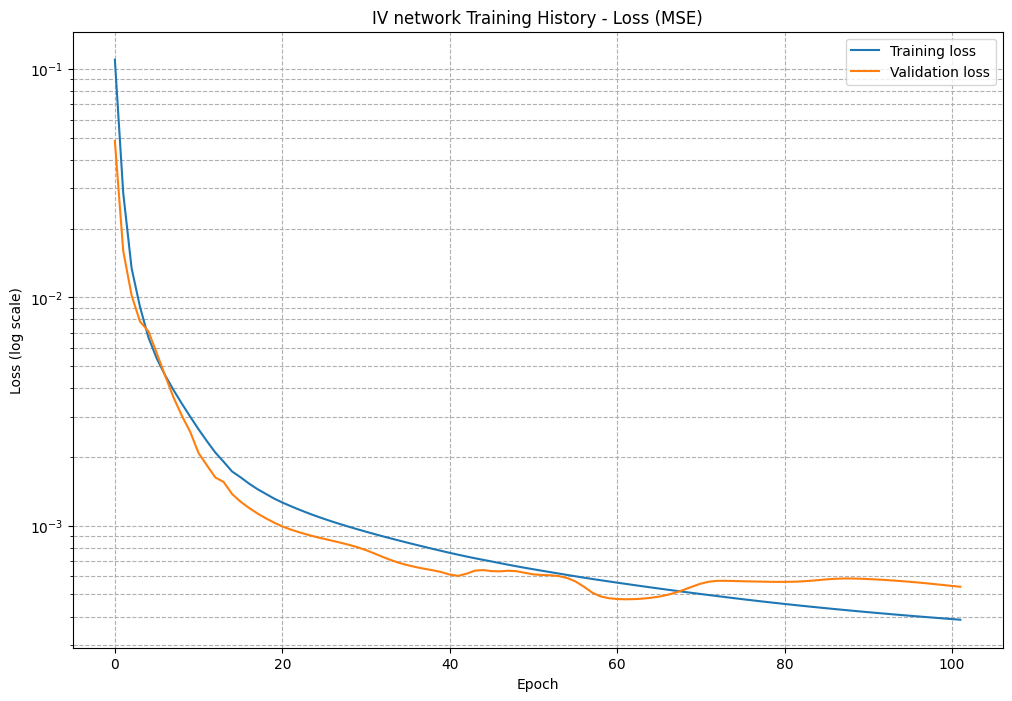


Final Training Loss: 3.8725e-04
Final Validation Loss: 5.3978e-04


In [9]:
import time
# EarlyStopping callback
earlystop = EarlyStopping(
    monitor='val_loss', 
    patience=40,       
    verbose=1,       
    restore_best_weights=True  # Restore the best model weights
)

# Callbacks
#reduce_lr = ReduceLROnPlateau(
#        monitor='val_loss',
#        factor=0.5,
#        patience=20,
#        min_lr=5e-5,
 #       verbose=1
 #   )

# Compile the model
modelpoint.compile(loss="mse", optimizer="adam")

# Train the model
start=time.time()
history = modelpoint.fit(
    x_train_transform, 
    y_train_transform, 
    batch_size=1024,
    validation_data=(x_val_transform, y_val_transform),
    epochs=400, 
    verbose=1, 
    shuffle=True, 
    callbacks=[earlystop]
)
end=time.time()
training_time=(end-start)
print("Training time :" ,training_time , "s" )

# Plot training history
plt.figure(figsize=(12, 8))  
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.yscale('log')
plt.title('IV network Training History - Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss (log scale)')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()

# Print final metrics
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]
print(f"\nFinal Training Loss: {final_train_loss:.4e}")
print(f"Final Validation Loss: {final_val_loss:.4e}")

# Evaluate the map on test data

4950/4950 ━━━━━━━━━━━━━━━━━━━━ 4s 879us/step

=== Performance on Standardized Scale ===
- MSE: 0.000526
- RMSE: 0.022926
- MAE: 0.014067

=== Performance on Original Scale ===
- MSE: 0.0000021
- RMSE: 0.001437 (0.45% of mean IV)
- MAE: 0.000882 (0.27% of mean IV)


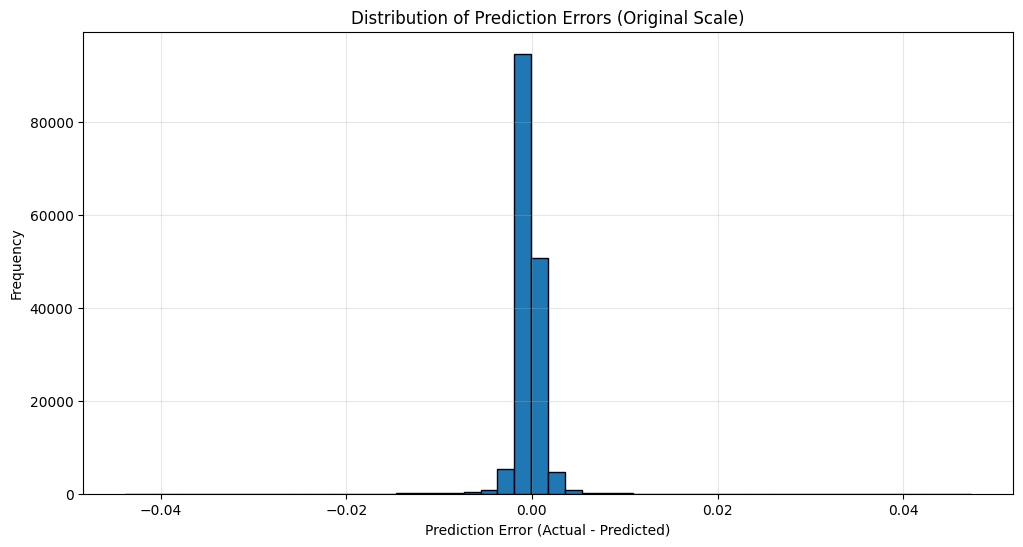

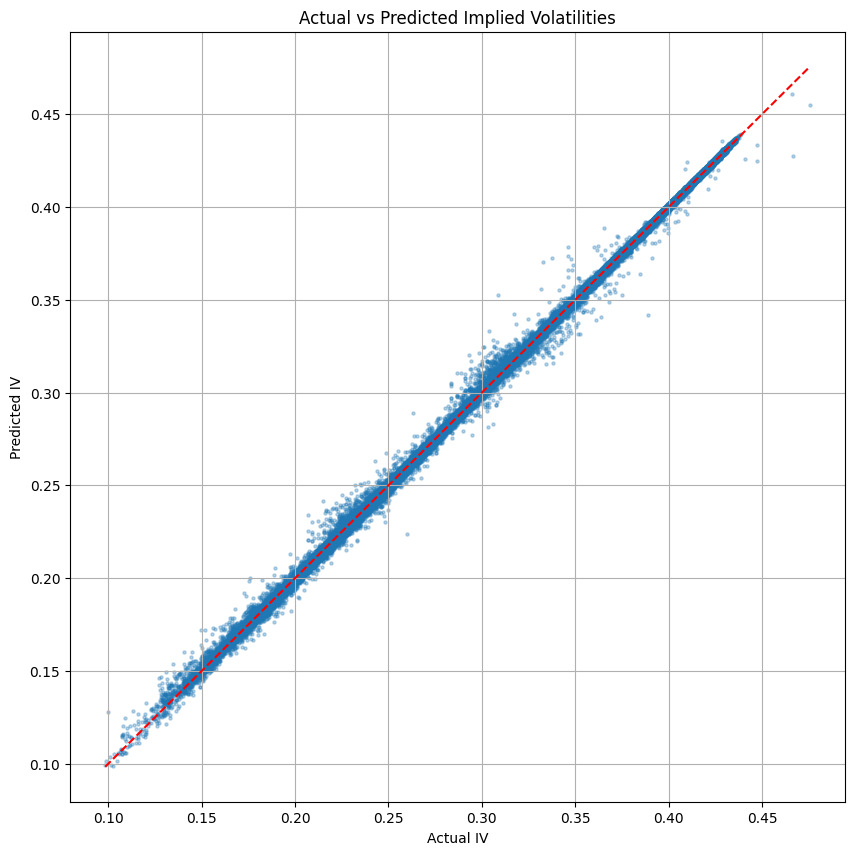

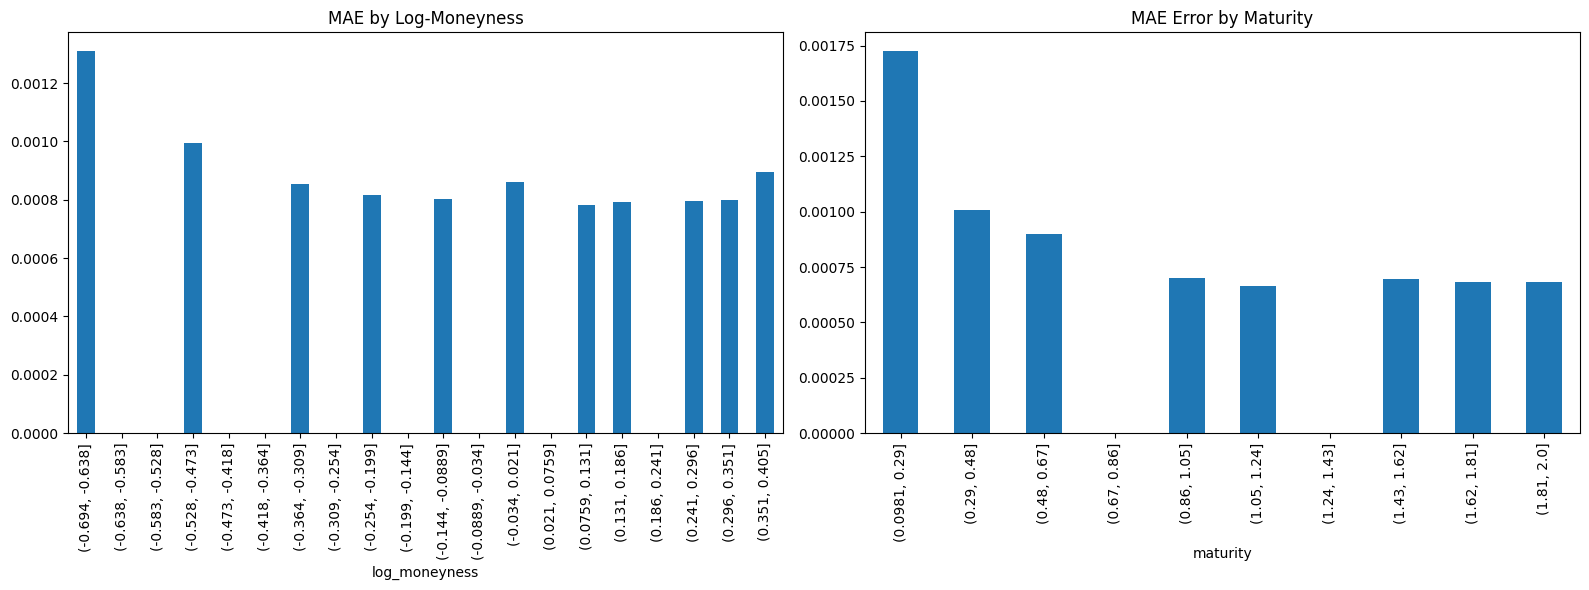

In [10]:
# Calculate predictions on test set
y_pred_transformed = modelpoint.predict(x_test_transform, verbose=1)

# 1) Evaluation on transformed scale (standardized volatilities)
mse_transformed = np.mean(np.square(y_test_transform - y_pred_transformed))
rmse_transformed = np.sqrt(mse_transformed)
mae_transformed = np.mean(np.abs(y_test_transform - y_pred_transformed))

print("\n=== Performance on Standardized Scale ===")
print(f"- MSE: {mse_transformed:.6f}")
print(f"- RMSE: {rmse_transformed:.6f}")
print(f"- MAE: {mae_transformed:.6f}")

# 2) Evaluation on original scale (implied volatilities)
y_pred_original = yinversetransform(y_pred_transformed)

mse_original = np.mean(np.square(y_test - y_pred_original))
rmse_original = np.sqrt(mse_original)
mae_original = np.mean(np.abs(y_test - y_pred_original))
mean_iv = np.mean(y_test)  # Reference for relative error

print("\n=== Performance on Original Scale ===")
print(f"- MSE: {mse_original:.7f}")
print(f"- RMSE: {rmse_original:.6f} ({(rmse_original/mean_iv)*100:.2f}% of mean IV)")
print(f"- MAE: {mae_original:.6f} ({(mae_original/mean_iv)*100:.2f}% of mean IV)")

# 3) Error distribution analysis
errors = y_test - y_pred_original
plt.figure(figsize=(12, 6))
plt.hist(errors, bins=50, edgecolor='black')
plt.title('Distribution of Prediction Errors (Original Scale)')
plt.xlabel('Prediction Error (Actual - Predicted)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

# 4) Scatter plot of predictions vs actual
plt.figure(figsize=(10, 10))
plt.scatter(y_test, y_pred_original, alpha=0.3, s=5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Actual vs Predicted Implied Volatilities')
plt.xlabel('Actual IV')
plt.ylabel('Predicted IV')
plt.grid(True)
plt.show()

# 5) Error by moneyness and maturity
df_test['prediction'] = y_pred_original
df_test['error'] = np.abs(errors)

# Aggregate errors by moneyness
moneyness_groups = pd.cut(df_test['log_moneyness'], bins=20)
error_by_moneyness = df_test.groupby(moneyness_groups)['error'].mean()

# Aggregate errors by maturity
maturity_groups = pd.cut(df_test['maturity'], bins=10)
error_by_maturity = df_test.groupby(maturity_groups)['error'].mean()

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
error_by_moneyness.plot(kind='bar', ax=ax1, title='MAE by Log-Moneyness')
error_by_maturity.plot(kind='bar', ax=ax2, title='MAE Error by Maturity')
plt.tight_layout()
plt.show()


Reshaping verification:
Original first maturity, first strike: 0.3031, Predicted: 0.3034
Reshaped [0,0,0]: 0.1014%
Original last maturity, last strike: 0.3512, Predicted: 0.3517
Reshaped [-1,-1,-1]: 0.1477%


C:\Users\pc\AppData\Local\Temp\ipykernel_18860\566456060.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"Original first maturity, first strike: {float(y_test[0]):.4f}, Predicted: {float(y_pred_original[0]):.4f}")
C:\Users\pc\AppData\Local\Temp\ipykernel_18860\566456060.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"Original last maturity, last strike: {float(y_test[-1]):.4f}, Predicted: {float(y_pred_original[-1]):.4f}")


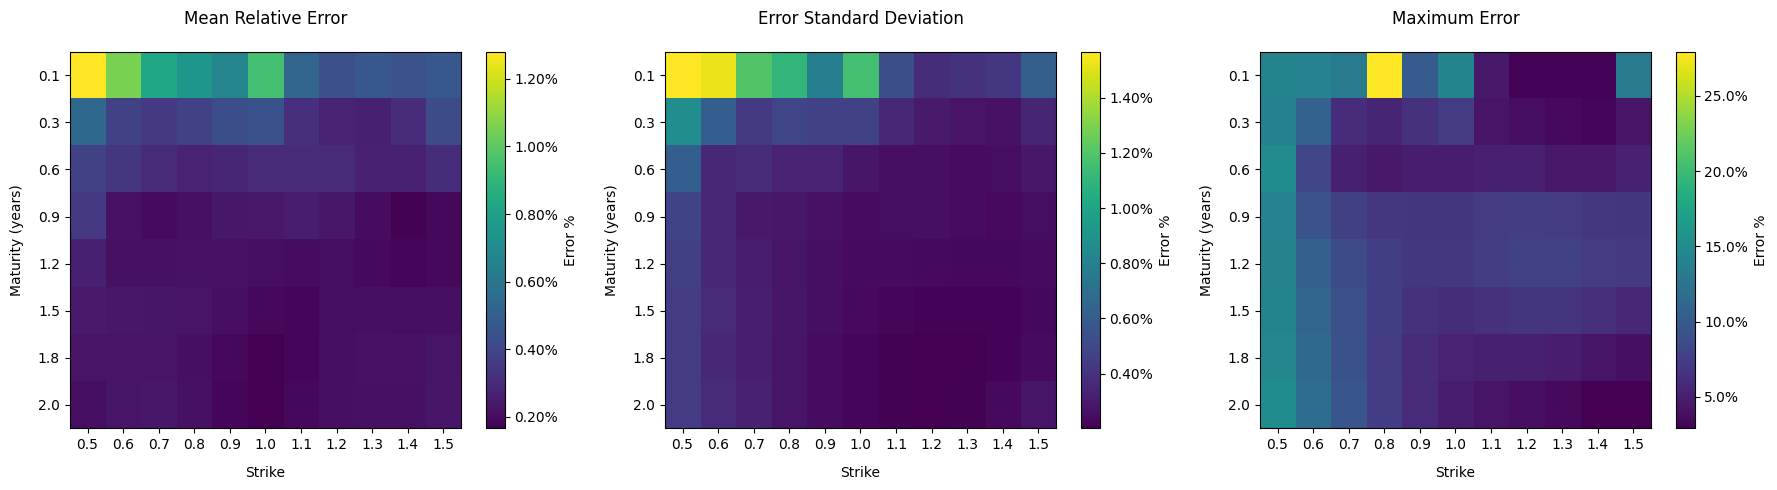


Error Statistics Across Entire Test Set:
Mean Error: 0.31%
Median Error: 0.20%
95th Percentile: 0.89%


In [11]:
# FURTHER INVESTIGATE THE ERRORS THE IV SURFACE.

# 1. Ensure shapes are correct
assert y_test.shape == y_pred_original.shape, "Shapes of y_test and y_pred_original must match"
n_samples = len(y_test) // (len(maturities) * len(strikes))
assert len(y_test) == n_samples * len(maturities) * len(strikes), "Total points must match n_samples × maturities × strikes"

# 2. Calculate relative errors (percentage)
relative_errors = np.abs((y_test - y_pred_original) / y_test) * 100  # Shape: (n_points,)
relative_errors = relative_errors.squeeze()

# 3. Reshape errors to (n_samples, 8 maturities, 11 strikes)
try:
    relative_errors_reshaped = relative_errors.reshape(n_samples, len(maturities), len(strikes))
except ValueError as e:
    raise ValueError(f"Reshape failed. Total points: {len(y_test)}, Expected shape: {n_samples}x{len(maturities)}x{len(strikes)}") from e

# 4. Verify reshaping order
print("\nReshaping verification:")
print(f"Original first maturity, first strike: {float(y_test[0]):.4f}, Predicted: {float(y_pred_original[0]):.4f}")
print(f"Reshaped [0,0,0]: {float(relative_errors_reshaped[0,0,0]):.4f}%")
print(f"Original last maturity, last strike: {float(y_test[-1]):.4f}, Predicted: {float(y_pred_original[-1]):.4f}")
print(f"Reshaped [-1,-1,-1]: {float(relative_errors_reshaped[-1,-1,-1]):.4f}%")

# 5. Create error plots
plt.figure(figsize=(18, 5))

# Plot 1: Mean Relative Error
plt.subplot(1, 3, 1)
mean_error = np.mean(relative_errors_reshaped, axis=0)
plt.imshow(mean_error, origin='upper', aspect='auto', cmap="viridis")
plt.colorbar(label='Error %', format=mtick.PercentFormatter())
plt.title("Mean Relative Error", pad=20)
plt.xlabel("Strike", labelpad=10)
plt.ylabel("Maturity (years)", labelpad=10)
plt.xticks(np.arange(len(strikes)), [f"{s}" for s in strikes])
plt.yticks(np.arange(len(maturities)), [f"{m}" for m in maturities])

# Plot 2: Standard Deviation
plt.subplot(1, 3, 2)
std_error = np.std(relative_errors_reshaped, axis=0)
plt.imshow(std_error, origin='upper', aspect='auto', cmap="viridis")
plt.colorbar(label='Error %', format=mtick.PercentFormatter())
plt.title("Error Standard Deviation", pad=20)
plt.xlabel("Strike", labelpad=10)
plt.ylabel("Maturity (years)", labelpad=10)
plt.xticks(np.arange(len(strikes)), [f"{s}" for s in strikes])
plt.yticks(np.arange(len(maturities)), [f"{m}" for m in maturities])

# Plot 3: Maximum Error
plt.subplot(1, 3, 3)
max_error = np.max(relative_errors_reshaped, axis=0)
plt.imshow(max_error, origin='upper', aspect='auto', cmap="viridis")
plt.colorbar(label='Error %', format=mtick.PercentFormatter())
plt.title("Maximum Error", pad=20)
plt.xlabel("Strike", labelpad=10)
plt.ylabel("Maturity (years)", labelpad=10)
plt.xticks(np.arange(len(strikes)), [f"{s}" for s in strikes])
plt.yticks(np.arange(len(maturities)), [f"{m}" for m in maturities])

plt.tight_layout()
plt.show()

# Additional diagnostics
print("\nError Statistics Across Entire Test Set:")
print(f"Mean Error: {np.mean(relative_errors):.2f}%")
print(f"Median Error: {np.median(relative_errors):.2f}%")
print(f"95th Percentile: {np.percentile(relative_errors, 95):.2f}%")

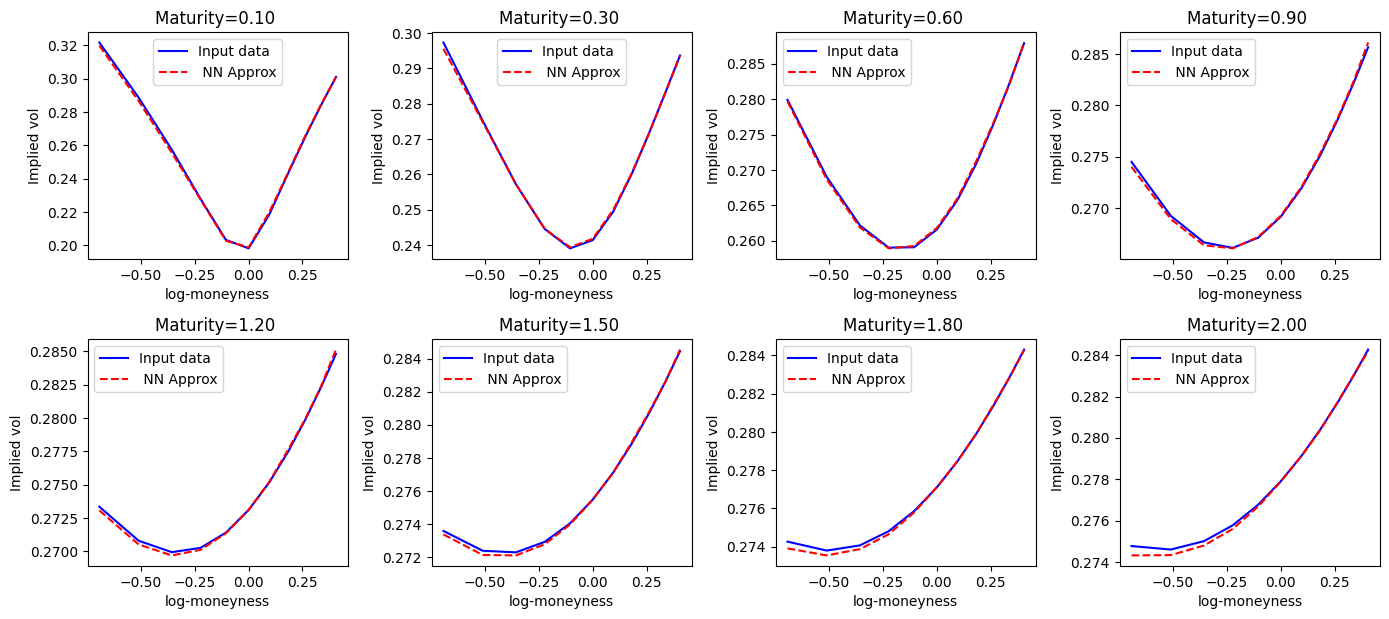

In [12]:
# FINALLY WE PLOT SAMPLE SMILES OF THE TEST SET

# Take a sample index from the test set
sample_ind = 512*88
y_sample = y_test[sample_ind:sample_ind+88].squeeze().T             #take corresponding (not processed)test sample
prediction = y_pred_original[sample_ind:sample_ind+88].squeeze().T  #take corresponding (converted)prediction

S0=1.0  #specify spot price
strikes_dim = len(strikes)

plt.figure(1,figsize=(14,12))
for i in range(len(maturities)):
    plt.subplot(4,4,i+1)
    
    plt.plot(np.log(strikes/S0),y_sample[i*strikes_dim:(i+1)*strikes_dim],'b',label="Input data")
    plt.plot(np.log(strikes/S0),prediction[i*strikes_dim:(i+1)*strikes_dim],'--r',label=" NN Approx")

    
    plt.title("Maturity=%1.2f "%maturities[i])
    plt.xlabel("log-moneyness")
    plt.ylabel("Implied vol")
    
    plt.legend()
plt.tight_layout()
plt.show()

# Optimizing the training
Numpy Implementation of the Neural Network tends to be faster than Keras

In [19]:
import scipy.optimize

# =====================================================================================
# EXTRACT TRAINED WEIGHTS FROM KERAS MODEL
# =====================================================================================

def extract_weights_from_keras_model(model):
    weights_and_biases = []
    for layer in model.layers:
        if hasattr(layer, 'get_weights') and layer.get_weights():
            weights, biases = layer.get_weights()
            weights_and_biases.append([weights, biases])
    return weights_and_biases

NNParameters = extract_weights_from_keras_model(modelpoint)

# =====================================================================================
# NUMPY IMPLEMENTATION OF THE NN AND GRADIENT
# =====================================================================================

NumLayers = 4  # Number of hidden layers

def elu(x):
    mask = x < 0
    out = x.copy()
    out[mask] = np.exp(out[mask]) - 1
    return out

def eluPrime(x):
    out = np.ones_like(x)
    mask = x < 0
    out[mask] = np.exp(x[mask])
    return out

def NeuralNetwork(x, strike, maturity):
    full_input = np.concatenate([x, [strike, maturity]])
    input1 = full_input

    for i in range(NumLayers):
        z = input1 @ NNParameters[i][0] + NNParameters[i][1]
        input1 = elu(z)

    output = input1 @ NNParameters[NumLayers][0] + NNParameters[NumLayers][1]
    return output.flatten()[0]

def NeuralNetworkGradient(x, strike, maturity):
    """
    Compute network gradient w.r.t. Heston parameters only
    Input:
        heston_params - array of 5 scaled Heston parameters
        strike - strike price (fixed)
        maturity - time to maturity (fixed)
    Output: Gradient vector of dimension (5,) - only w.r.t. Heston params
    """
    # Concatenate full input
    full_input = np.concatenate([x, [strike, maturity]])
    
    # Forward pass with intermediate storage
    activations = [full_input.copy()]
    z_values = []
    
    input1 = full_input.copy()
    
    # Forward pass through hidden layers
    for i in range(NumLayers):
        z = np.dot(input1, NNParameters[i][0]) + NNParameters[i][1]
        input1 = elu(z)
        z_values.append(z)
        activations.append(input1.copy())
    
    # Output layer
    i += 1
    z_out = np.dot(input1, NNParameters[i][0]) + NNParameters[i][1]
    
    # Backward pass - start from output
    # Initialize gradient w.r.t. full input (7 dimensions)
    grad_full = np.zeros(7)
    
    # Output layer gradient (linear activation, so derivative = 1)
    delta = np.ones(1)  # Scalar output
    
    # Gradient w.r.t. last hidden layer
    grad_hidden = delta.dot(NNParameters[NumLayers][0].T)
    
    # Backpropagate through hidden layers
    for i in reversed(range(NumLayers)):
        # Gradient w.r.t. pre-activation
        grad_z = grad_hidden * eluPrime(z_values[i])
        
        # Gradient w.r.t. input of this layer
        if i == 0:
            # First layer - gradient w.r.t. network input
            grad_full = grad_z.dot(NNParameters[i][0].T)
        else:
            # Hidden layer - gradient w.r.t. previous activation
            grad_hidden = grad_z.dot(NNParameters[i][0].T)
    
    # Return only gradients w.r.t. Heston parameters (first 5 elements)
    return grad_full[:5]


In [20]:
from typing import Tuple

# =====================================================================================
# PARAMETER SCALING UTILITIES
# =====================================================================================

def unscale_heston_params(scaled_params: np.ndarray) -> np.ndarray:
    """Convert scaled parameters back to original scale"""
    return scaled_params * (ub - lb) * 0.5 + (ub + lb) * 0.5

# =====================================================================================
# SURFACE COST FUNCTION AND GRADIENT (VECTORIZED)
# =====================================================================================

def surface_cost_function(scaled_params: np.ndarray, 
                          strikes: np.ndarray, 
                          maturities: np.ndarray, 
                          market_ivs: np.ndarray) -> tuple[float, np.ndarray]:

    n_points = len(strikes)
    # Prepare input batch
    batch_input = np.column_stack([
        np.tile(scaled_params, (n_points, 1)),
        strikes.reshape(-1, 1),
        maturities.reshape(-1, 1)
    ])

    # Forward pass vectorized
    activations = batch_input.copy()
    for i in range(NumLayers):
        z = activations @ NNParameters[i][0] + NNParameters[i][1]
        activations = elu(z)
    
    outputs = activations @ NNParameters[NumLayers][0] + NNParameters[NumLayers][1]
    outputs = outputs.flatten()

    # Loss
    residuals = outputs - market_ivs
    total_loss = np.sum(residuals**2)

    # Gradient
    total_gradient = np.zeros_like(scaled_params)
    for i in range(n_points):
        grad = NeuralNetworkGradient(scaled_params, strikes[i], maturities[i])
        total_gradient += 2 * residuals[i] * grad

    return total_loss, total_gradient

In [22]:
# Initialize arrays
n_surfaces = 1800
n_methods = 4
n_params = 5

methods = ["L-BFGS-B", "SLSQP", "BFGS", "Levenberg-Marquardt"]
init_guess = np.zeros(5)  # Initial guess in [-1,1] scaled space
bounds = [(-1, 1)] * 5

# Prepare calibration data
calibration_data = []
for i in range(n_surfaces):
    start_idx = i * 88
    end_idx = (i+1) * 88
    strikes = x_test_transform[start_idx:end_idx, 5]
    maturities = x_test_transform[start_idx:end_idx, 6]
    market_ivs = y_test_transform[start_idx:end_idx, 0]
    calibration_data.append((strikes, maturities, market_ivs))

# Main calibration loop

# =====================================================================================
# OPTIMIZATION LOOP
# =====================================================================================

solutions = np.zeros((n_surfaces, n_methods, n_params))  # [surface, method, param]
times = np.zeros((n_surfaces, n_methods))

# Main calibration loop
for surface_idx in range(n_surfaces):
    print(f"Calibrating surface {surface_idx+1}/{n_surfaces}", end="\r")
    strikes, maturities, market_ivs = calibration_data[surface_idx]

    def fun(x):
        loss, _ = surface_cost_function(x, strikes, maturities, market_ivs)
        return loss

    def jac(x):
        _, grad = surface_cost_function(x, strikes, maturities, market_ivs)
        return grad

    def ls_fun(x):
        n = len(strikes)
        return np.array([
            NeuralNetwork(x, strikes[i], maturities[i]) - market_ivs[i]
            for i in range(n)
        ])

    def ls_jac(x):
        n = len(strikes)
        J = np.zeros((n, 5))
        for i in range(n):
            J[i, :] = NeuralNetworkGradient(x, strikes[i], maturities[i])
        return J

    # L-BFGS-B
    t0 = time.perf_counter()
    res = scipy.optimize.minimize(fun, init_guess, method='L-BFGS-B', jac=jac,
                                    bounds=bounds, tol=1e-10, options={"maxiter": 5000})
    t1 = time.perf_counter()
    solutions[surface_idx, 0, :] = unscale_heston_params(res.x)
    times[surface_idx, 0] = t1 - t0

    # SLSQP
    t0 = time.perf_counter()
    res = scipy.optimize.minimize(fun, init_guess, method='SLSQP', jac=jac,
                                    bounds=bounds, tol=1e-10, options={"maxiter": 5000})
    t1 = time.perf_counter()
    solutions[surface_idx, 1, :] = unscale_heston_params(res.x)
    times[surface_idx, 1] = t1 - t0

    # BFGS
    t0 = time.perf_counter()
    res = scipy.optimize.minimize(fun, init_guess, method='BFGS', jac=jac,
                                    tol=1e-10, options={"maxiter": 5000})
    t1 = time.perf_counter()
    solutions[surface_idx, 2, :] = unscale_heston_params(res.x)
    times[surface_idx, 2] = t1 - t0

    # Levenberg-Marquardt
    t0 = time.perf_counter()
    res = scipy.optimize.least_squares(ls_fun, init_guess, jac=ls_jac,
                                        gtol=1e-10)
    t1 = time.perf_counter()
    solutions[surface_idx, 3, :] = unscale_heston_params(res.x)
    times[surface_idx, 3] = t1 - t0

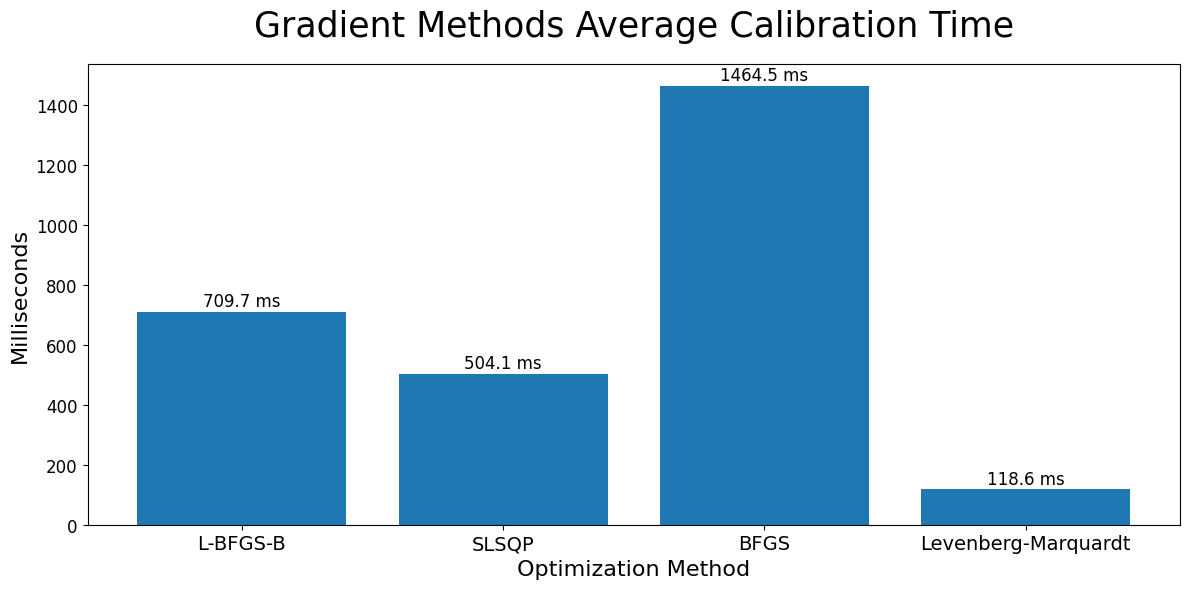

In [23]:
# =====================================================================================
# RESULTS ANALYSIS AND VISUALIZATION
# =====================================================================================

# Calculate average times in milliseconds
avg_times_ms = np.mean(times, axis=0) * 1000

# Plot settings
plt.figure(1, figsize=(12, 6))
bars = plt.bar(methods, avg_times_ms)

# Add exact numerical values above each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 5,
             f'{height:.1f} ms',
             ha='center', va='bottom', fontsize=12)

# Formatting
plt.title("Gradient Methods Average Calibration Time", fontsize=25, pad=20)
plt.ylabel("Milliseconds", fontsize=16)
plt.xlabel("Optimization Method", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=12)

# Adjust layout to prevent text clipping
plt.tight_layout()
plt.show()

Calibrated parameters shape: (1800, 5)
Test parameters shape: (1800, 5)


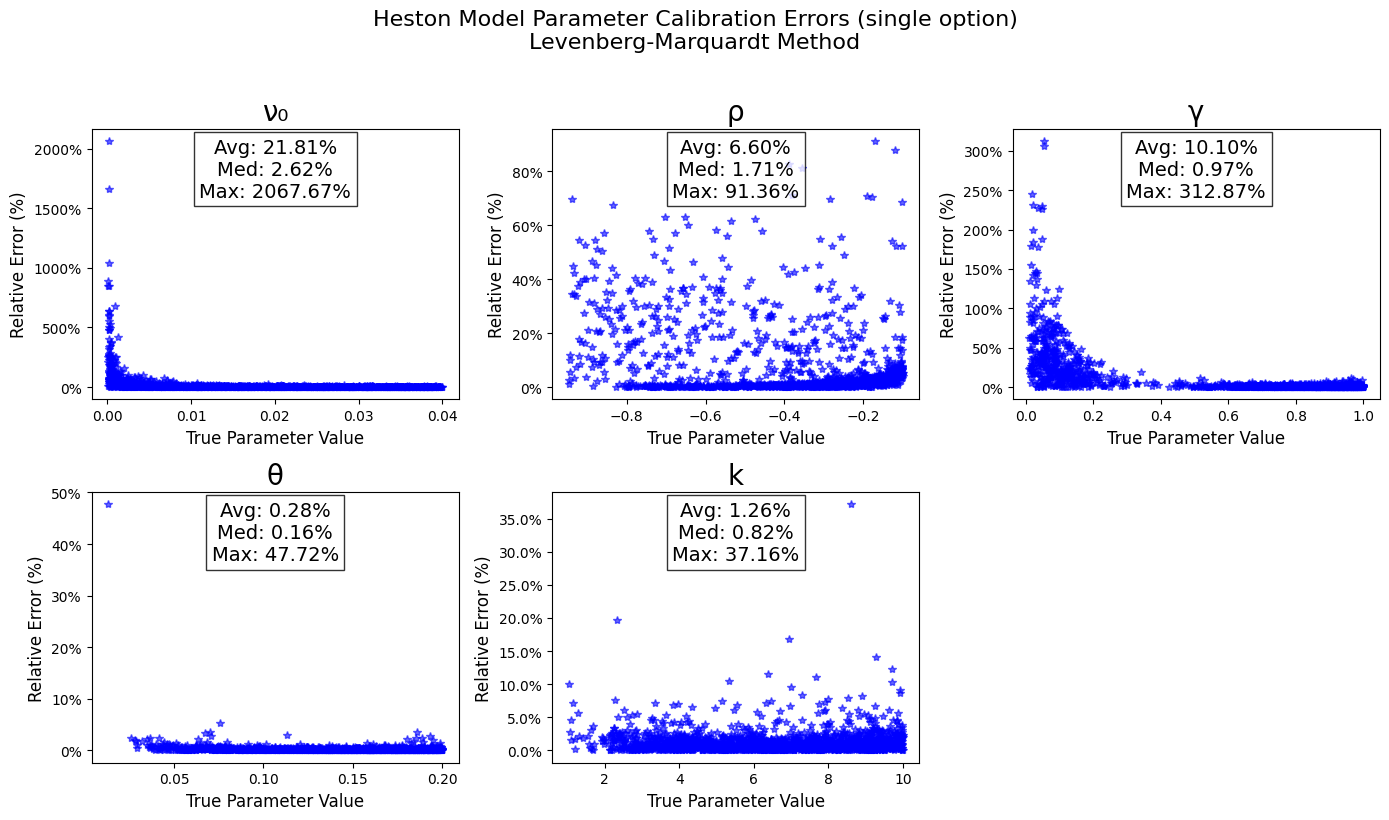


Summary Statistics of Relative Errors (%):
ν₀: Avg=21.81%, Med=2.62%, Max=2067.67%
ρ: Avg=6.60%, Med=1.71%, Max=91.36%
γ: Avg=10.10%, Med=0.97%, Max=312.87%
θ: Avg=0.28%, Med=0.16%, Max=47.72%
k: Avg=1.26%, Med=0.82%, Max=37.16%


In [ ]:
# Extract Levenberg-Marquardt parameters (usually the best performing)
LMParameters = solutions[:, 3, :]

# Extract unique Heston parameters from X_test (remove duplicates and strike/maturity columns)
# Since parameters are repeated 88 times for each surface, we take every 88th row
X_test_compare = X_test[::88, :5]  # Take every 88th row and first 5 columns

# Verify shapes
print(f"Calibrated parameters shape: {LMParameters.shape}")  # Should be (1800, 5)
print(f"Test parameters shape: {X_test_compare.shape}")      # Should be (1800, 5)

# Verify dimensions
assert len(LMParameters) == len(X_test_compare), "Mismatch between calibrated parameters and test set"

# Plot relative errors for each parameter
titles = ["ν₀", "ρ", "γ", "θ", "k"]
relative_errors = np.zeros((len(LMParameters), 5))  # Store all relative errors

fig = plt.figure(figsize=(14, 8))
for param_idx in range(5):
    ax = plt.subplot(2, 3, param_idx+1)
    
    # Get true and calibrated parameters
    true_params = X_test_compare[:len(LMParameters), param_idx]
    calibrated_params = LMParameters[:, param_idx]
    
    # Calculate relative errors 
    with np.errstate(divide='ignore', invalid='ignore'):
        rel_errors = np.abs(calibrated_params - true_params) / np.abs(true_params)
    
    relative_errors[:, param_idx] = rel_errors
    
    # Plot
    plt.plot(true_params, 100 * rel_errors, 'b*', alpha=0.6)
    plt.title(titles[param_idx], fontsize=20)
    plt.xlabel('True Parameter Value', fontsize=12)
    plt.ylabel('Relative Error (%)', fontsize=12)
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
    
    # Add statistics
    stats_text = 'Avg: %1.2f%%\nMed: %1.2f%%\nMax: %1.2f%%' % (
        np.mean(100 * rel_errors),
        np.median(100 * rel_errors),
        np.max(100 * rel_errors))
    
    plt.text(0.5, 0.85, stats_text,
             horizontalalignment='center',
             verticalalignment='center',
             transform=ax.transAxes,
             fontsize=14,
             bbox=dict(facecolor='white', alpha=0.8))

plt.suptitle('Heston Model Parameter Calibration Errors (single option)\nLevenberg-Marquardt Method', 
             fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# Additional analysis
print("\nSummary Statistics of Relative Errors (%):")
for i, title in enumerate(titles):
    print(f"{title}: Avg={np.mean(100*relative_errors[:,i]):.2f}%, "
          f"Med={np.median(100*relative_errors[:,i]):.2f}%, "
          f"Max={np.max(100*relative_errors[:,i]):.2f}%")

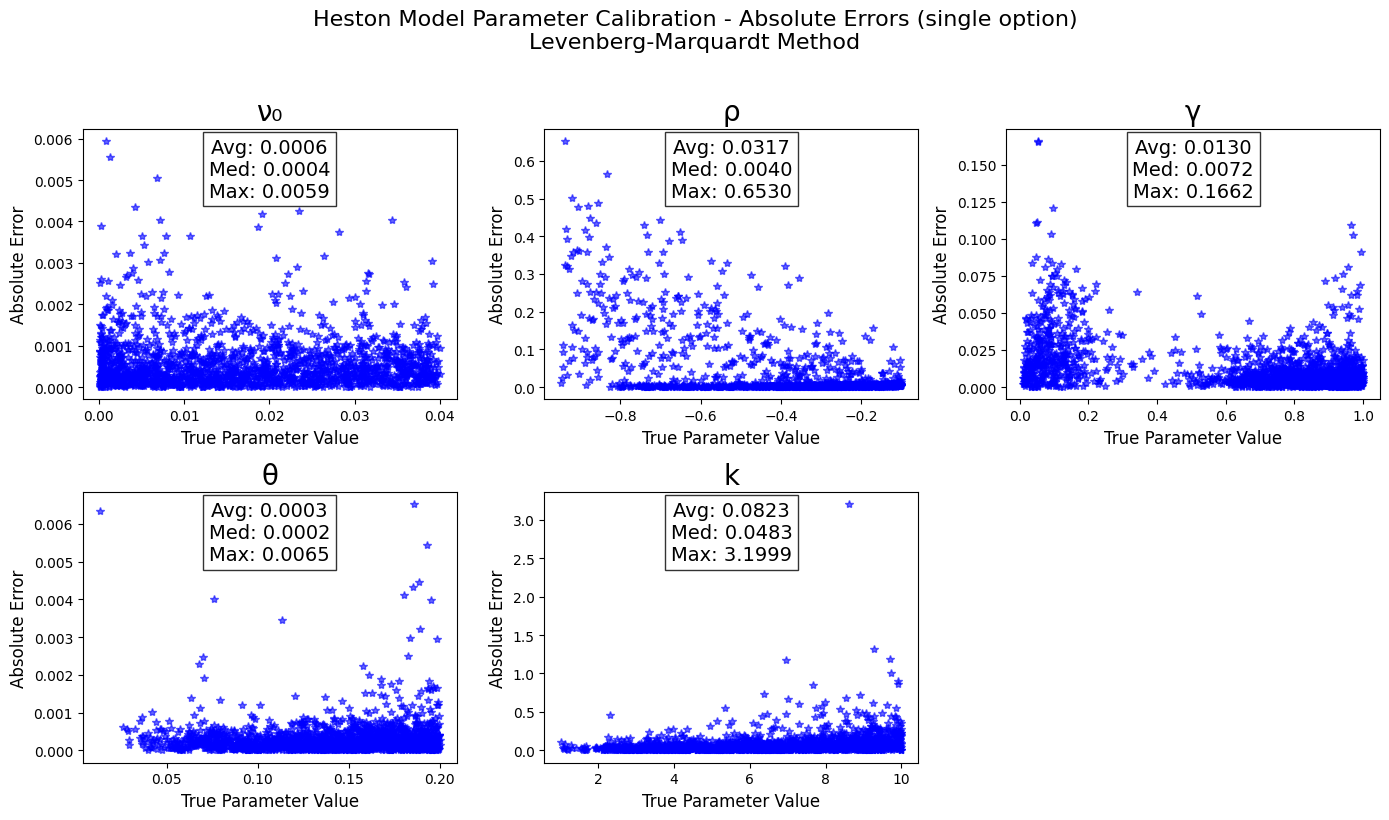


Summary Statistics of Absolute Errors:
ν₀: Avg=0.000584, Med=0.000395, Max=0.005949
ρ: Avg=0.031743, Med=0.004022, Max=0.652977
γ: Avg=0.012989, Med=0.007193, Max=0.166163
θ: Avg=0.000318, Med=0.000218, Max=0.006522
k: Avg=0.082315, Med=0.048328, Max=3.199900


In [ ]:
# Correct parameter names and absolute error analysis
titles = ["ν₀", "ρ", "γ", "θ", "k"]
absolute_errors = np.zeros((len(LMParameters), 5))  # Store all absolute errors

fig = plt.figure(figsize=(14, 8))
for param_idx in range(5):
    ax = plt.subplot(2, 3, param_idx+1)
    
    # Get true and calibrated parameters
    true_params = X_test_compare[:len(LMParameters), param_idx]
    calibrated_params = LMParameters[:, param_idx]
    
    # Calculate absolute errors
    abs_errors = np.abs(calibrated_params - true_params)
    absolute_errors[:, param_idx] = abs_errors
    
    # Plot
    plt.plot(true_params, abs_errors, 'b*', alpha=0.6)
    plt.title(titles[param_idx], fontsize=20)
    plt.xlabel('True Parameter Value', fontsize=12)
    plt.ylabel('Absolute Error', fontsize=12)
    
    # Add statistics
    stats_text = 'Avg: %1.4f\nMed: %1.4f\nMax: %1.4f' % (
        np.mean(abs_errors),
        np.median(abs_errors),
        np.max(abs_errors))
    
    plt.text(0.5, 0.85, stats_text,
             horizontalalignment='center',
             verticalalignment='center',
             transform=ax.transAxes,
             fontsize=14,
             bbox=dict(facecolor='white', alpha=0.8))

plt.suptitle('Heston Model Parameter Calibration - Absolute Errors (single option)\nLevenberg-Marquardt Method', 
             fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# Additional analysis
print("\nSummary Statistics of Absolute Errors:")
for i, title in enumerate(titles):
    print(f"{title}: Avg={np.mean(absolute_errors[:,i]):.6f}, "
          f"Med={np.median(absolute_errors[:,i]):.6f}, "
          f"Max={np.max(absolute_errors[:,i]):.6f}")

# Gradient-free optimization
And here we will exploit 3 different gradient free optimization methods: **COBYLA**, **Differential Evolution** and **Nelder-Mayer**.
We will use this configuration of parameters for these algorithms and compare both accuracy and calibration time.

In [ ]:
# =====================================================================================
# GRADIENT-FREE CALIBRATION WITH DIFFERENT ALGORITHMS
# =====================================================================================

# Define parameter bounds in scaled space [-1, 1] for all parameters
bounds_scaled = [(-1, 1) for _ in range(5)]

# Initialize arrays for results
n_surfaces = 360
n_methods = 3
n_params = 5

solutions_gf = np.zeros((n_surfaces, n_methods, n_params))  # [surface, method, param]
times_gf = np.zeros((n_surfaces, n_methods))

methods = ["COBYLA", "Differential Evolution", "Nelder-Mead"]
init_guess = np.zeros(5)  # Initial guess in [-1,1] scaled space

print("Starting Gradient-Free Calibration...")
print(f"Total surfaces to calibrate: {n_surfaces}")

# Main calibration loop
for surface_idx in range(n_surfaces):
    print(f"Calibrating surface {surface_idx+1}/{n_surfaces}", end="\r")
    strikes, maturities, market_ivs = calibration_data[surface_idx]
    
    # Define cost function for this surface, same as before without the gradient (note: it takes directly the current market data being inside the loop, no need to pass them)
    def fun(x):
        loss, _ = surface_cost_function(x, strikes, maturities, market_ivs)
        return loss
    
    # COBYLA (Constrained Optimization BY Linear Approximation)
    start = time.perf_counter()
    result = scipy.optimize.minimize(
        fun,
        x0=init_guess,
        method='COBYLA',
        bounds=bounds_scaled,
        options={
            "maxiter": 5000,
            "disp": False,
            "catol": 1e-8,
            "tol": 1e-10
        }
    )
    solutions_gf[surface_idx, 0, :] = unscale_heston_params(result.x)
    times_gf[surface_idx, 0] = time.perf_counter() - start
    
    # Differential Evolution
    start = time.perf_counter()
    result = scipy.optimize.differential_evolution(
        fun,
        bounds=bounds_scaled,
        popsize=50,
        strategy='best1bin',
        mutation=0.65,
        recombination=0.7,
        tol=0.01,
        maxiter=1000,
        disp=False,
        seed=42
    )
    solutions_gf[surface_idx, 1, :] = unscale_heston_params(result.x)
    times_gf[surface_idx, 1] = time.perf_counter() - start
    
    # Nelder-Mead (Simplex method)
    start = time.perf_counter()
    result = scipy.optimize.minimize(
        fun,
        x0=init_guess,
        method='Nelder-Mead',
        options={
            "maxiter": 5000,
            "maxfev": 10000,
            "disp": False,
            "xatol": 1e-8,
            "fatol": 1e-10,
            "adaptive": True
        }
    )
    solutions_gf[surface_idx, 2, :] = unscale_heston_params(result.x)
    times_gf[surface_idx, 2] = time.perf_counter() - start

print("\nGradient-Free Calibration completed!")

Starting Gradient-Free Calibration...
Total surfaces to calibrate: 360
Calibrating surface 360/360
Gradient-Free Calibration completed!


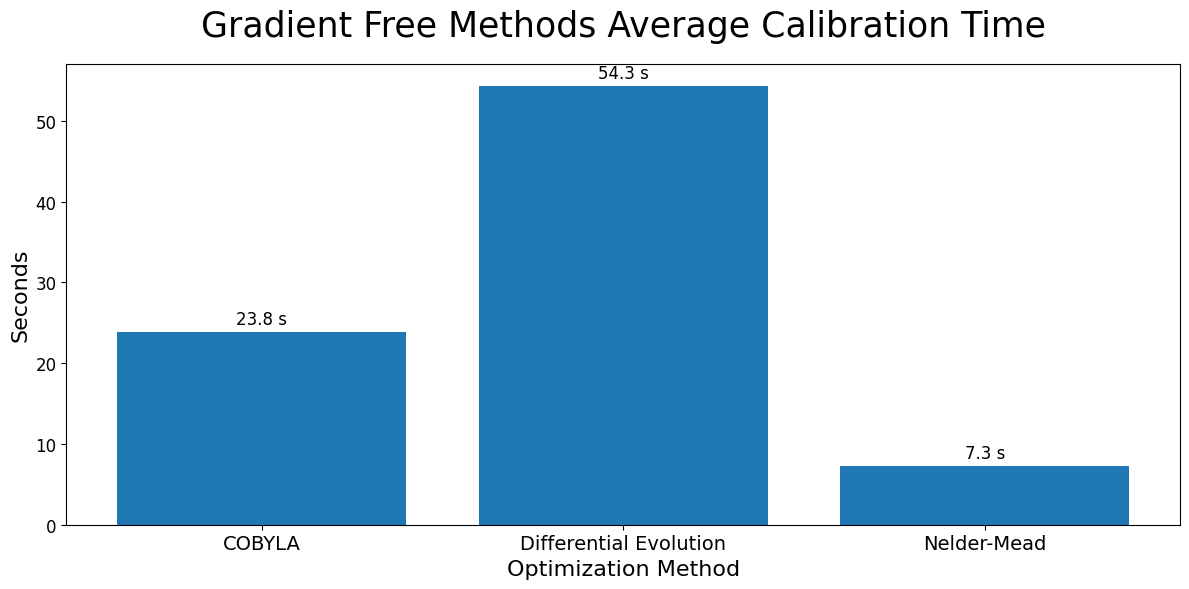

In [ ]:
# =====================================================================================
# RESULTS ANALYSIS AND VISUALIZATION
# =====================================================================================

# Calculate average times in milliseconds
avg_times_ms = np.mean(times_gf, axis=0)

# Plot settings
plt.figure(1, figsize=(12, 6))
bars = plt.bar(methods, avg_times_ms)

# Add exact numerical values above each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.25,
             f'{height:.1f} s',
             ha='center', va='bottom', fontsize=12)

# Formatting
plt.title("Gradient Free Methods Average Calibration Time", fontsize=25, pad=20)
plt.ylabel("Seconds", fontsize=16)
plt.xlabel("Optimization Method", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=12)

# Adjust layout to prevent text clipping
plt.tight_layout()
plt.show()

Calibrated parameters shape: (360, 5)
Test parameters shape: (360, 5)


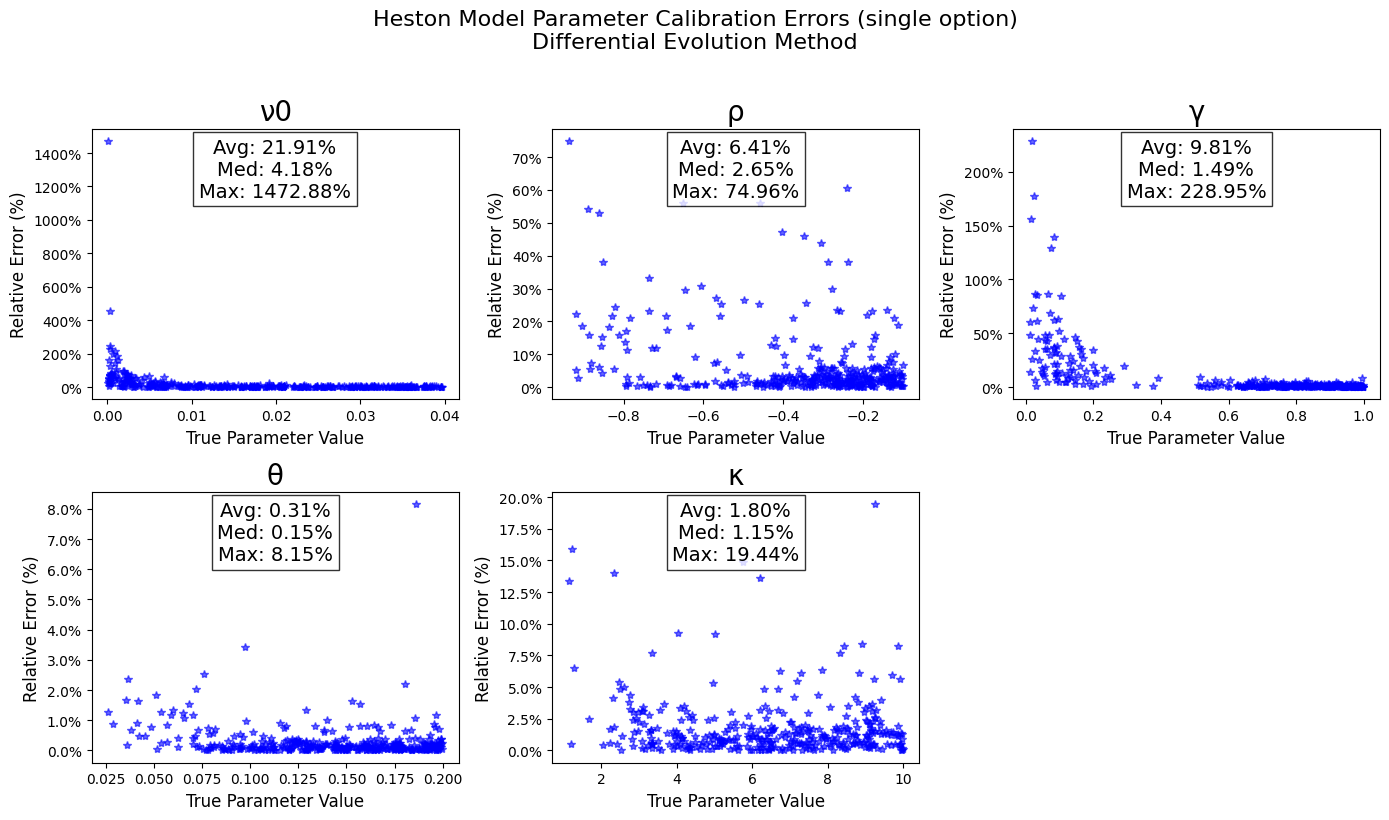


Summary Statistics of Relative Errors (%):
ν0: Avg=21.91%, Med=4.18%, Max=1472.88%
ρ: Avg=6.41%, Med=2.65%, Max=74.96%
γ: Avg=9.81%, Med=1.49%, Max=228.95%
θ: Avg=0.31%, Med=0.15%, Max=8.15%
κ: Avg=1.80%, Med=1.15%, Max=19.44%


In [ ]:
# Extract Differential Evolution parameters (usually the best performing)
DEParameters = solutions_gf[:, 1, :]

# Extract unique Heston parameters from X_test (remove duplicates and strike/maturity columns)
# Since parameters are repeated 88 times for each surface, we take every 88th row
X_test_compare = X_test[::88, :5]  # Take every 88th row and first 5 columns
X_test_compare = X_test_compare[:n_surfaces,:]

# Verify shapes
print(f"Calibrated parameters shape: {DEParameters.shape}")  # Should be (360, 5)
print(f"Test parameters shape: {X_test_compare.shape}")      # Should be (360, 5)

# Verify dimensions
assert len(DEParameters) == len(X_test_compare), "Mismatch between calibrated parameters and test set"

# Plot relative errors for each parameter
titles = ["ν₀", "ρ", "γ", "θ", "κ"]
relative_errors = np.zeros((len(DEParameters), 5))  # Store all relative errors

fig = plt.figure(figsize=(14, 8))
for param_idx in range(5):
    ax = plt.subplot(2, 3, param_idx+1)
    
    # Get true and calibrated parameters
    true_params = X_test_compare[:, param_idx]
    calibrated_params = DEParameters[:, param_idx]
    
    # Calculate relative errors
    with np.errstate(divide='ignore', invalid='ignore'):
        rel_errors = np.abs(calibrated_params - true_params) / np.abs(true_params)
    
    relative_errors[:, param_idx] = rel_errors
    
    # Plot
    plt.plot(true_params, 100 * rel_errors, 'b*', alpha=0.6)
    plt.title(titles[param_idx], fontsize=20)
    plt.xlabel('True Parameter Value', fontsize=12)
    plt.ylabel('Relative Error (%)', fontsize=12)
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
    
    # Add statistics
    stats_text = 'Avg: %1.2f%%\nMed: %1.2f%%\nMax: %1.2f%%' % (
        np.mean(100 * rel_errors),
        np.median(100 * rel_errors),
        np.max(100 * rel_errors))
    
    plt.text(0.5, 0.85, stats_text,
             horizontalalignment='center',
             verticalalignment='center',
             transform=ax.transAxes,
             fontsize=14,
             bbox=dict(facecolor='white', alpha=0.8))

plt.suptitle('Heston Model Parameter Calibration Errors (single option)\nDifferential Evolution Method', 
             fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# Additional analysis
print("\nSummary Statistics of Relative Errors (%):")
for i, title in enumerate(titles):
    print(f"{title}: Avg={np.mean(100*relative_errors[:,i]):.2f}%, "
          f"Med={np.median(100*relative_errors[:,i]):.2f}%, "
          f"Max={np.max(100*relative_errors[:,i]):.2f}%")

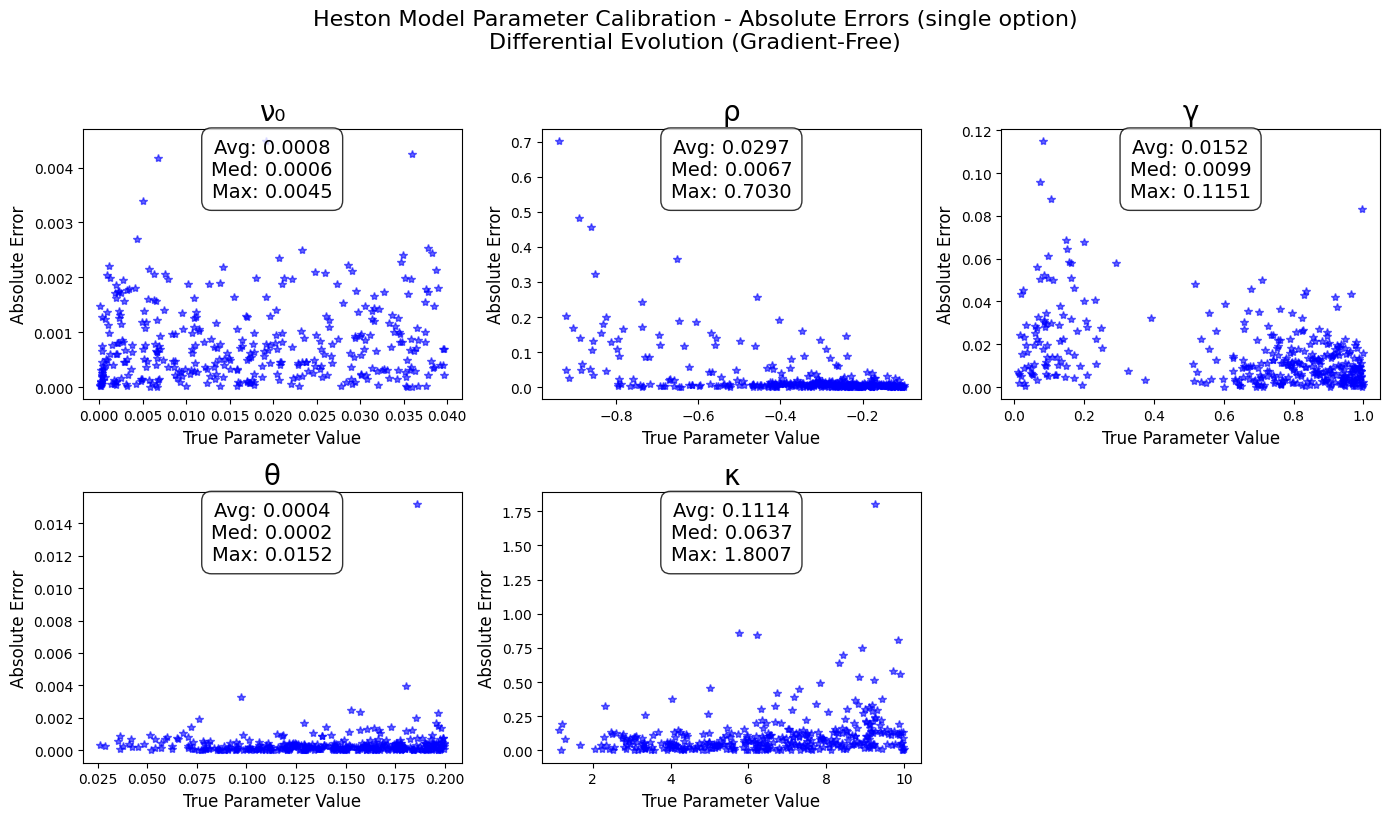


Summary Statistics of Absolute Errors:
ν₀: Avg=0.000808, Med=0.000631, Max=0.004487
ρ: Avg=0.029738, Med=0.006695, Max=0.703038
γ: Avg=0.015158, Med=0.009949, Max=0.115057
θ: Avg=0.000385, Med=0.000200, Max=0.015160
κ: Avg=0.111353, Med=0.063672, Max=1.800687


In [ ]:
# Plot absolute errors for each parameter
titles = ["ν₀", "ρ", "γ", "θ", "κ"]
absolute_errors = np.zeros((len(DEParameters), 5))  # Store all absolute errors

fig = plt.figure(figsize=(14, 8))
for param_idx in range(5):
    ax = plt.subplot(2, 3, param_idx+1)
    
    # Get true and calibrated parameters
    true_params = X_test_compare[:, param_idx]
    calibrated_params = DEParameters[:, param_idx]
    
    # Calculate absolute errors
    abs_errors = np.abs(calibrated_params - true_params)
    absolute_errors[:, param_idx] = abs_errors
    
    # Plot with consistent style
    plt.plot(true_params, abs_errors, 'b*', alpha=0.6)
    plt.title(titles[param_idx], fontsize=20)
    plt.xlabel('True Parameter Value', fontsize=12)
    plt.ylabel('Absolute Error', fontsize=12)
    
    # Add statistics with consistent formatting
    stats_text = 'Avg: %1.4f\nMed: %1.4f\nMax: %1.4f' % (
        np.mean(abs_errors),
        np.median(abs_errors),
        np.max(abs_errors))
    
    plt.text(0.5, 0.85, stats_text,
             horizontalalignment='center',
             verticalalignment='center',
             transform=ax.transAxes,
             fontsize=14,
             bbox=dict(facecolor='white', alpha=0.8,
                      boxstyle='round,pad=0.5'))

plt.suptitle('Heston Model Parameter Calibration - Absolute Errors (single option)\nDifferential Evolution (Gradient-Free)', 
             fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# Additional analysis with consistent output format
print("\nSummary Statistics of Absolute Errors:")
for i, title in enumerate(titles):
    print(f"{title}: Avg={np.mean(absolute_errors[:,i]):.6f}, "
          f"Med={np.median(absolute_errors[:,i]):.6f}, "
          f"Max={np.max(absolute_errors[:,i]):.6f}")

In [ ]:
# ORIGINAL OLD VERSION 
import scipy.optimize

def extract_weights_from_keras_model(model):
    """
    Extract weights and bias from the trained keras network, format for Numpy usage
    """
    weights_and_biases = []
    
    # Extract weights and biases for each layer
    for layer in model.layers:
        if hasattr(layer, 'get_weights') and layer.get_weights():
            weights, biases = layer.get_weights()
            weights_and_biases.append([weights, biases])
    
    return weights_and_biases

# Extract parameters from trained model
NNParameters = extract_weights_from_keras_model(modelpoint)

# =====================================================================================
# NUMPY IMPLEMENTATION OF THE NN (FASTER THAN KERAS)
# =====================================================================================

# Network hyperparameters
NumLayers = 4  # 4 hidden layers
InputSize = 7   # 5 Heston params + strike + maturity
OutputSize = 1  # 1 implied volatility (single option)
HestonParamSize = 5

def elu(x):
    """
    ELU activation function
    """
    return np.where(x < 0, np.exp(x) - 1, x)

def eluPrime(x):
    """
    ELU derivative
    """
    return np.where(x < 0, np.exp(x), 1.0)

def NeuralNetwork(heston_params, strike, maturity):
    """
    Forward pass of NN for single option
    Input: 
        heston_params - array of 5 scaled Heston parameters
        strike - strike price
        maturity - time to maturity
    Output: single implied volatility
    """
    # Concatenate full input: [heston_params, strike, maturity]
    full_input = np.concatenate([heston_params, [strike, maturity]])
    
    input1 = full_input.copy()
    
    # Hidden layers with ELU activation
    for i in range(NumLayers):
        input1 = np.dot(input1, NNParameters[i][0]) + NNParameters[i][1]
        input1 = elu(input1)
    
    # Output layer (linear)
    i += 1
    output = np.dot(input1, NNParameters[i][0]) + NNParameters[i][1]
    
    return output.item()  # Return scalar

def NeuralNetworkGradient(heston_params, strike, maturity):
    """
    Compute network gradient w.r.t. Heston parameters only
    Input:
        heston_params - array of 5 scaled Heston parameters
        strike - strike price (fixed)
        maturity - time to maturity (fixed)
    Output: Gradient vector of dimension (5,) - only w.r.t. Heston params
    """
    # Concatenate full input
    full_input = np.concatenate([heston_params, [strike, maturity]])
    
    # Forward pass with intermediate storage
    activations = [full_input.copy()]
    z_values = []
    
    input1 = full_input.copy()
    
    # Forward pass through hidden layers
    for i in range(NumLayers):
        z = np.dot(input1, NNParameters[i][0]) + NNParameters[i][1]
        input1 = elu(z)
        z_values.append(z)
        activations.append(input1.copy())
    
    # Output layer
    i += 1
    z_out = np.dot(input1, NNParameters[i][0]) + NNParameters[i][1]
    
    # Backward pass - start from output
    # Initialize gradient w.r.t. full input (7 dimensions)
    grad_full = np.zeros(InputSize)
    
    # Output layer gradient (linear activation, so derivative = 1)
    delta = np.ones(OutputSize)  # Scalar output
    
    # Gradient w.r.t. last hidden layer
    grad_hidden = delta.dot(NNParameters[NumLayers][0].T)
    
    # Backpropagate through hidden layers
    for i in reversed(range(NumLayers)):
        # Gradient w.r.t. pre-activation
        grad_z = grad_hidden * eluPrime(z_values[i])
        
        # Gradient w.r.t. input of this layer
        if i == 0:
            # First layer - gradient w.r.t. network input
            grad_full = grad_z.dot(NNParameters[i][0].T)
        else:
            # Hidden layer - gradient w.r.t. previous activation
            grad_hidden = grad_z.dot(NNParameters[i][0].T)
    
    # Return only gradients w.r.t. Heston parameters (first 5 elements)
    return grad_full[:HestonParamSize]

from typing import Tuple

# =====================================================================================
# PARAMETER SCALING UTILITIES
# =====================================================================================

def unscale_heston_params(scaled_params: np.ndarray) -> np.ndarray:
    """Convert scaled parameters back to original scale"""
    return scaled_params * (ub - lb) * 0.5 + (ub + lb) * 0.5

# =====================================================================================
# SINGLE SURFACE CALIBRATION FUNCTIONS
# =====================================================================================

def surface_cost_function(scaled_params: np.ndarray, 
                         strikes: np.ndarray, 
                         maturities: np.ndarray, 
                         market_ivs: np.ndarray) -> Tuple[float, np.ndarray]:
    """
    Compute MSE cost and gradient for a single volatility surface
    
    Args:
        scaled_params: 5 scaled Heston parameters in [-1,1] range
        strikes: Array of strike prices for the surface
        maturities: Array of maturities for the surface
        market_ivs: Array of market implied volatilities
    
    Returns:
        tuple: (mse_loss, gradient)
    """
    total_loss = 0.0
    total_gradient = np.zeros_like(scaled_params)
    n_points = len(strikes)
    
    for i in range(n_points):
        # Forward pass
        pred_iv = NeuralNetwork(scaled_params, strikes[i], maturities[i])
        error = pred_iv - market_ivs[i]
        
        # Gradient computation
        grad = NeuralNetworkGradient(scaled_params, strikes[i], maturities[i])
        
        # Accumulate loss and gradient
        total_loss += error**2
        total_gradient += 2 * error * grad
    
    return total_loss/n_points, total_gradient/n_points

def surface_residuals(scaled_params: np.ndarray,
                     strikes: np.ndarray,
                     maturities: np.ndarray,
                     market_ivs: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Compute residuals and Jacobian for least-squares optimization
    
    Args:
        scaled_params: 5 scaled Heston parameters in [-1,1] range
        strikes: Array of strike prices
        maturities: Array of maturities
        market_ivs: Array of market implied volatilities
    
    Returns:
        tuple: (residuals, Jacobian)
    """
    n_points = len(strikes)
    residuals = np.zeros(n_points)
    jacobian = np.zeros((n_points, 5))
    
    for i in range(n_points):
        # Forward pass
        pred_iv = NeuralNetwork(scaled_params, strikes[i], maturities[i])
        residuals[i] = pred_iv - market_ivs[i]
        
        # Jacobian row
        jacobian[i,:] = NeuralNetworkGradient(scaled_params, strikes[i], maturities[i])
    
    return residuals, jacobian

# Initialize arrays
n_surfaces = 1800
n_methods = 4
n_params = 5

solutions = np.zeros((n_surfaces, n_methods, n_params))  # [surface, method, param]
times = np.zeros((n_surfaces, n_methods))

methods = ["L-BFGS-B", "SLSQP", "BFGS", "Levenberg-Marquardt"]
init_guess = np.zeros(5)  # Initial guess in [-1,1] scaled space

# Prepare calibration data
calibration_data = []
for i in range(n_surfaces):
    start_idx = i * 88
    end_idx = (i+1) * 88
    strikes = x_test_transform[start_idx:end_idx, 5]
    maturities = x_test_transform[start_idx:end_idx, 6]
    market_ivs = y_test_transform[start_idx:end_idx, 0]
    calibration_data.append((strikes, maturities, market_ivs))

# Main calibration loop
for surface_idx in range(n_surfaces):
    print(f"Calibrating surface {surface_idx+1}/{n_surfaces}", end="\r")
    strikes, maturities, market_ivs = calibration_data[surface_idx]
    
    # L-BFGS-B
    start = time.time()
    result = scipy.optimize.minimize(
        fun=lambda x: surface_cost_function(x, strikes, maturities, market_ivs),
        x0=init_guess,
        method='L-BFGS-B',
        jac=True,
        bounds=[(-1., 1.)]*5,
        tol=1e-10,
        options={"maxiter": 5000}
    )
    solutions[surface_idx, 0, :] = unscale_heston_params(result.x)
    times[surface_idx, 0] = time.time() - start
    
    # SLSQP
    start = time.time()
    result = scipy.optimize.minimize(
        fun=lambda x: surface_cost_function(x, strikes, maturities, market_ivs),
        x0=init_guess,
        method='SLSQP',
        jac=True,
        bounds=[(-1., 1.)]*5,
        tol=1e-10,
        options={"maxiter": 5000}
    )
    solutions[surface_idx, 1, :] = unscale_heston_params(result.x)
    times[surface_idx, 1] = time.time() - start
    
    # BFGS (senza bounds)
    start = time.time()
    result = scipy.optimize.minimize(
        fun=lambda x: surface_cost_function(x, strikes, maturities, market_ivs),
        x0=init_guess,
        method='BFGS',
        jac=True,
        tol=1e-10,
        options={"maxiter": 5000}
    )
    solutions[surface_idx, 2, :] = unscale_heston_params(result.x)
    times[surface_idx, 2] = time.time() - start
    
    # Levenberg-Marquardt
    start = time.time()
    result = scipy.optimize.least_squares(
        fun=lambda x: surface_residuals(x, strikes, maturities, market_ivs)[0],
        x0=init_guess,
        jac=lambda x: surface_residuals(x, strikes, maturities, market_ivs)[1],
        method='lm',
        gtol=1e-10,
        max_nfev=5000
    )
    solutions[surface_idx, 3, :] = unscale_heston_params(result.x)
    times[surface_idx, 3] = time.time() - start